In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics

In [35]:
book_movie = pd.read_csv('book_movie_database.csv')

In [36]:
book_movie.columns

Index(['book_title', 'book_rating', 'book_number_ratings',
       'book_year_published', 'popularity', 'release_date', 'movie_runtime',
       'movie_rating', 'movie_number_ratings', 'genres'],
      dtype='object')

In [37]:
book_movie = book_movie[['book_title', 'book_rating', 'book_number_ratings',
       'book_year_published', 'popularity', 'release_date', 'movie_runtime','movie_number_ratings', 'genres','movie_rating']]

In [38]:
book_movie.describe().round(1)

,book_rating,book_number_ratings,book_year_published,popularity,movie_runtime,movie_number_ratings,movie_rating
count,692.0,692.0,692.0,692.0,692.0,692.0,692.0
mean,3.9,338229.4,1938.2,8.0,112.6,595.5,6.4
std,0.2,565192.8,96.3,8.3,32.2,1162.9,0.9
min,3.1,209.0,1536.0,0.0,25.0,1.0,2.0
25%,3.8,34436.0,1920.2,2.5,95.0,20.0,5.9
50%,3.9,151602.0,1975.5,6.8,107.5,131.5,6.5
75%,4.1,403176.5,1998.0,10.8,125.0,635.8,7.0
max,4.6,5680570.0,2018.0,88.4,386.0,9678.0,8.8


In [6]:
#Let's examine the initial relationship between our variables
book_movie.corr()

,book_rating,book_number_ratings,book_year_published,popularity,movie_runtime,movie_number_ratings,movie_rating
book_rating,1.000000,0.237532,0.024509,0.082068,0.001495,0.200784,0.272215
book_number_ratings,0.237532,1.000000,-0.063233,0.183304,0.119640,0.341852,0.114020
book_year_published,0.024509,-0.063233,1.000000,0.249751,-0.099355,0.212469,0.052478
popularity,0.082068,0.183304,0.249751,1.000000,0.093390,0.685483,0.283196
movie_runtime,0.001495,0.119640,-0.099355,0.093390,1.000000,0.126660,0.160130
movie_number_ratings,0.200784,0.341852,0.212469,0.685483,0.126660,1.000000,0.338677
movie_rating,0.272215,0.114020,0.052478,0.283196,0.160130,0.338677,1.000000


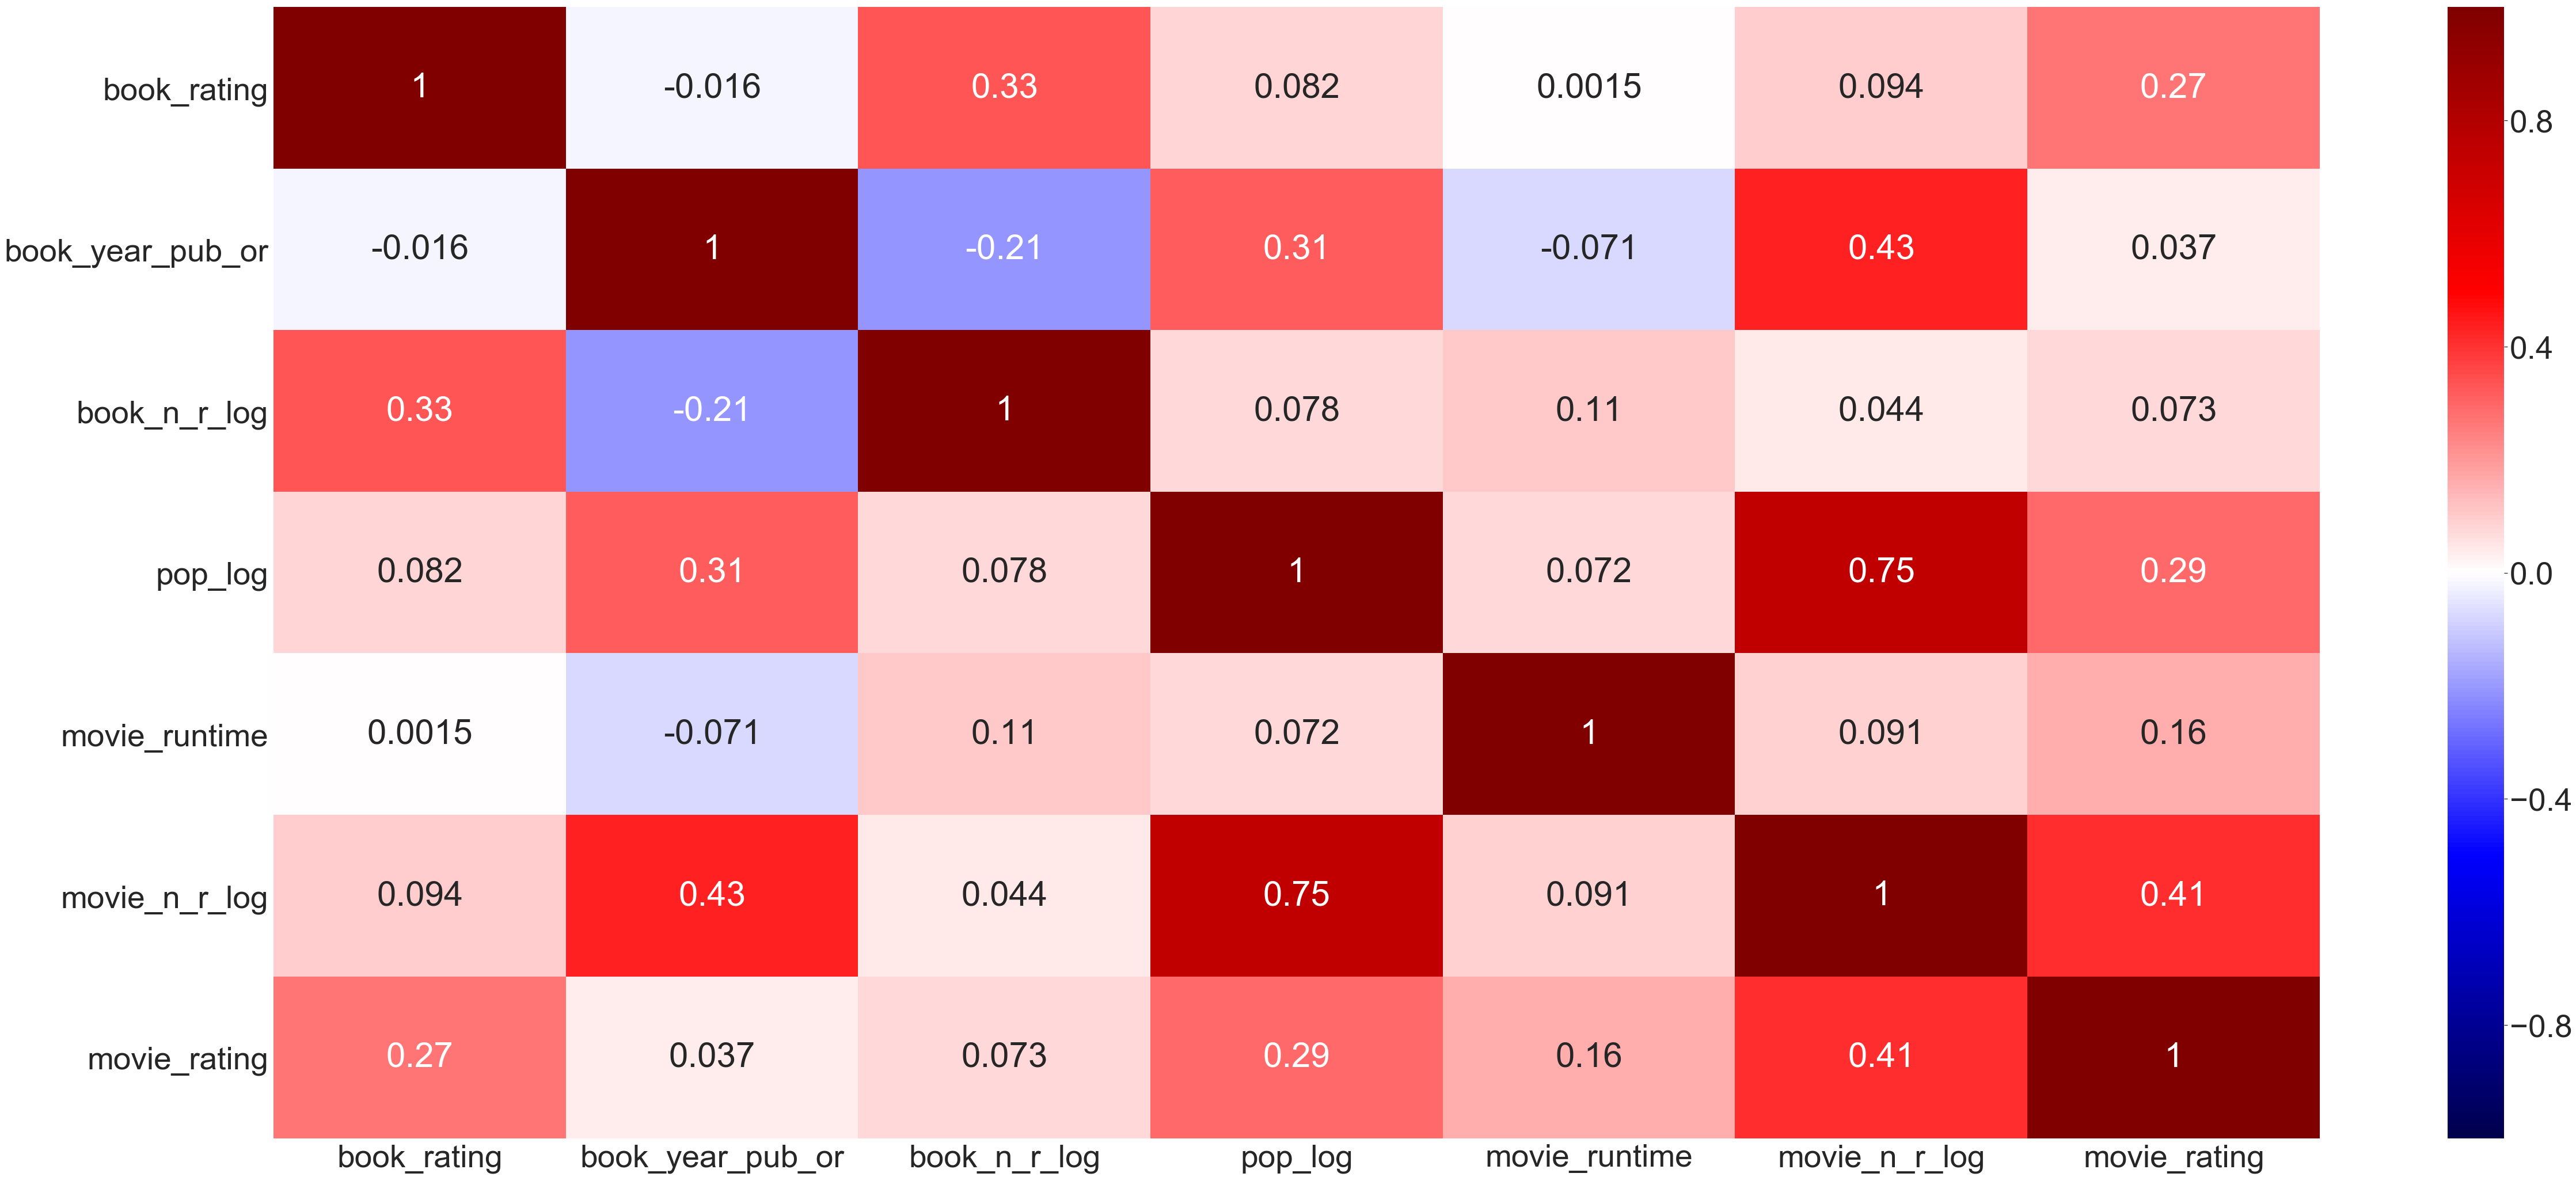

In [250]:
sns.set(font_scale=5) 
plt.figure(figsize=(70,30))
sns_plot = sns.heatmap(book_movie.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1);
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("book_vs_movie_heatmap.svg")

<Figure size 3600x3600 with 0 Axes>

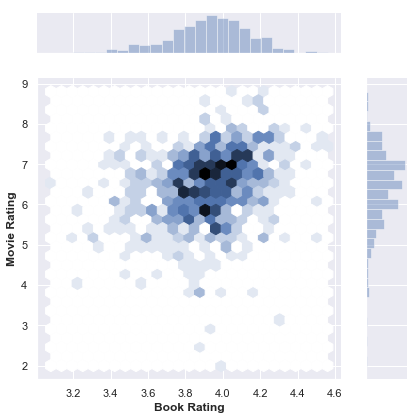

In [16]:
sns.set(font_scale=1) 
plt.figure(figsize=(50,50))
fig = sns.jointplot(x="book_rating", y="movie_rating", kind = 'hex', data=book_movie);
fig.ax_joint.set_xlabel('Book Rating', fontweight='bold')
fig.ax_joint.set_ylabel('Movie Rating', fontweight='bold')
plt.tight_layout()
fig.savefig("book_vs_movie.svg")

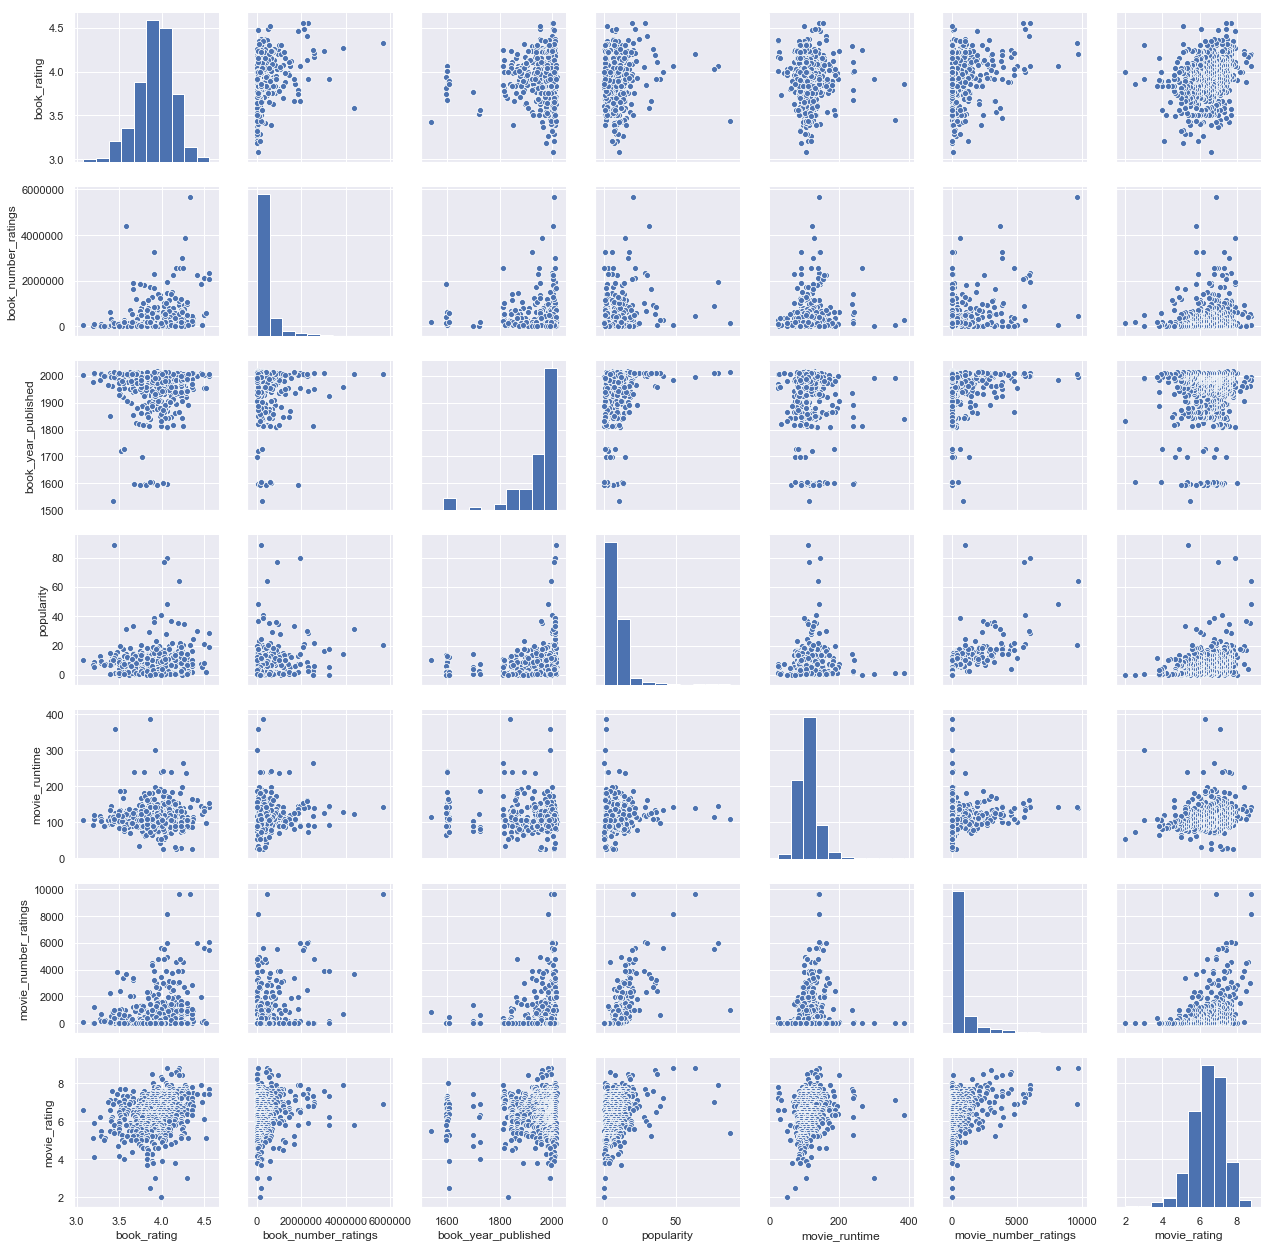

In [100]:
#Examine the histrograms:
sns.set(font_scale=1) 
sns.pairplot(book_movie);

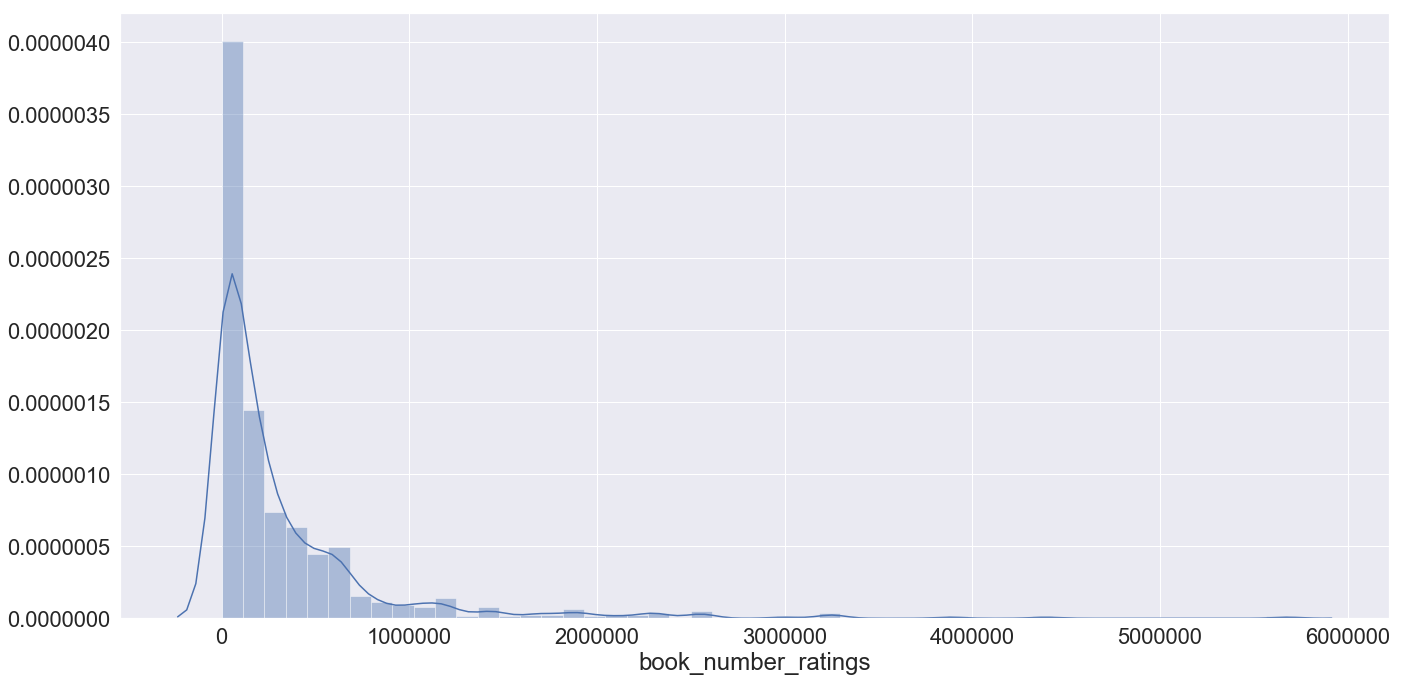

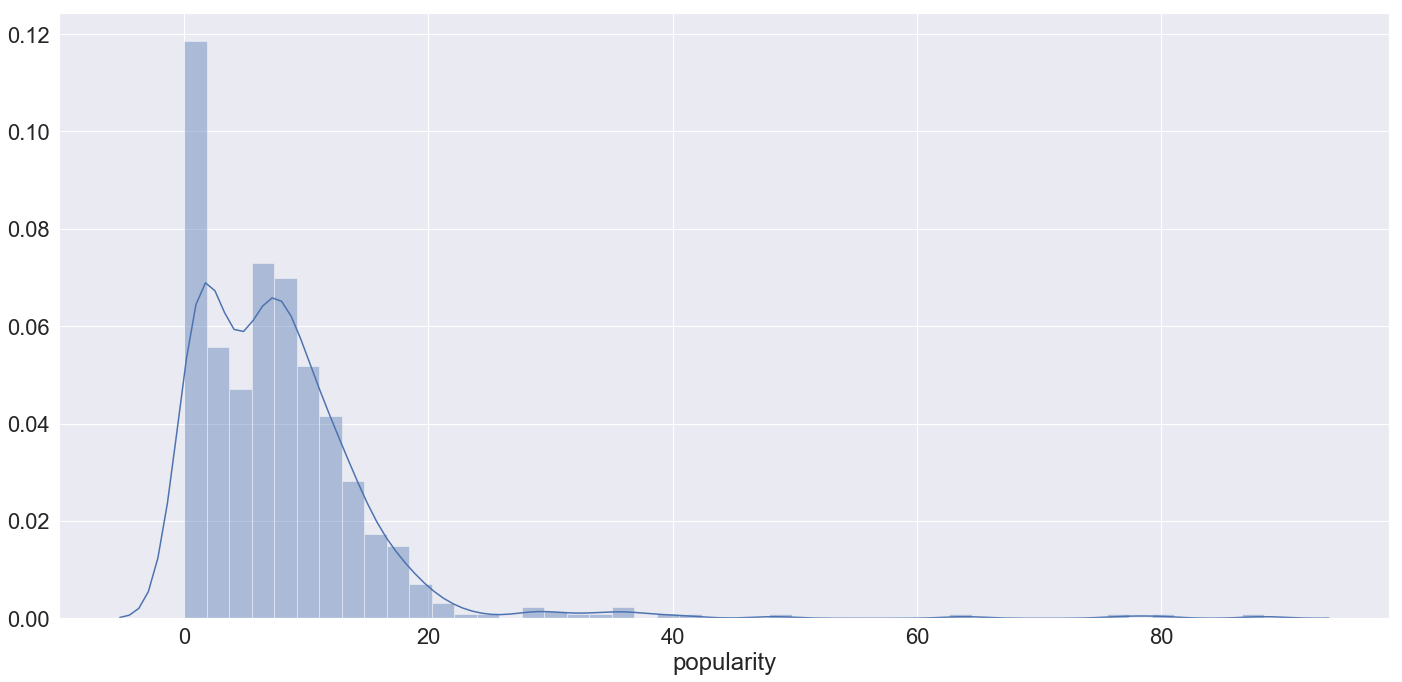

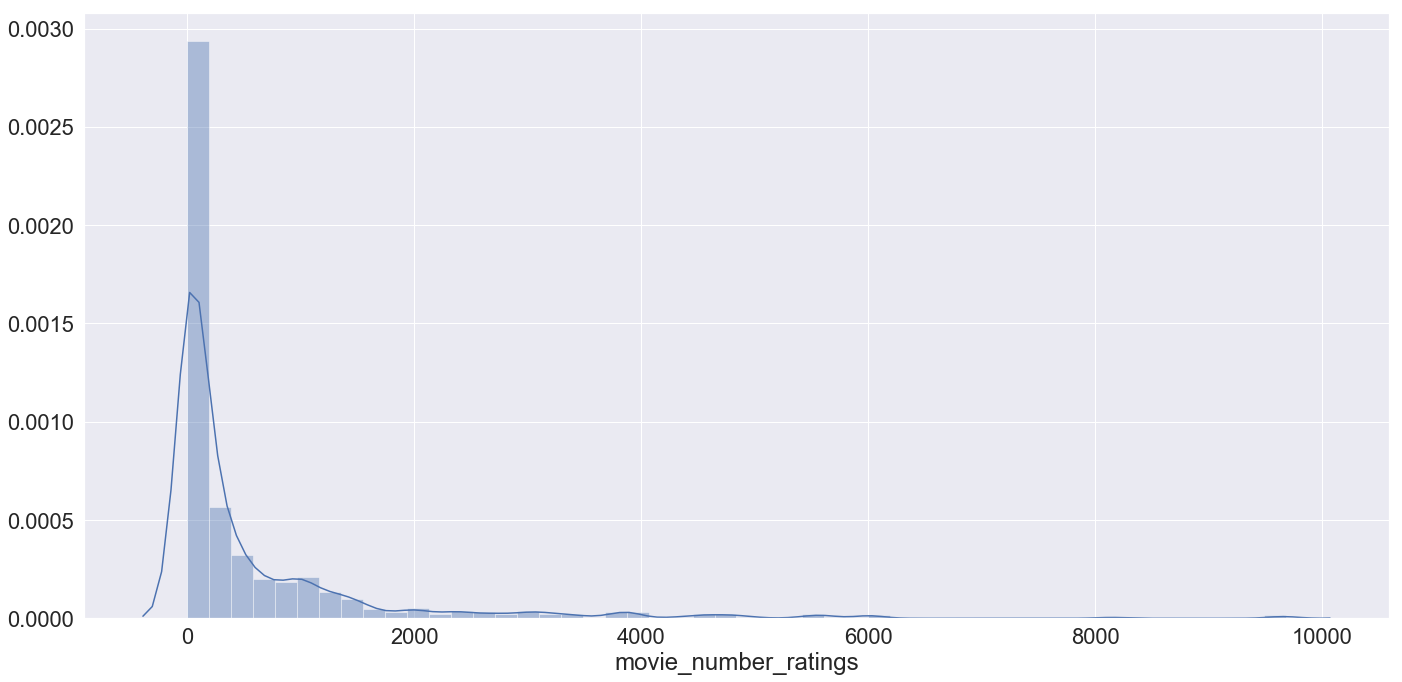

In [101]:
#These features appear heavily skewed:
#book_number_ratings
#movie_number_ratings
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns_plot = sns.distplot(book_movie['book_number_ratings'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("book_number_ratings.svg")

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns_plot = sns.distplot(book_movie['popularity'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("popularity.svg")

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns_plot = sns.distplot(book_movie['movie_number_ratings'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("movie_number_ratings.svg")

#They are good candidates for a log transformation

In [102]:
#Applying the log transformation to those features:

book_movie['pop_log'] = np.log(book_movie['popularity'])
book_movie['book_n_r_log'] = np.log(book_movie['book_number_ratings'])
book_movie['movie_n_r_log'] = np.log(book_movie['movie_number_ratings'])

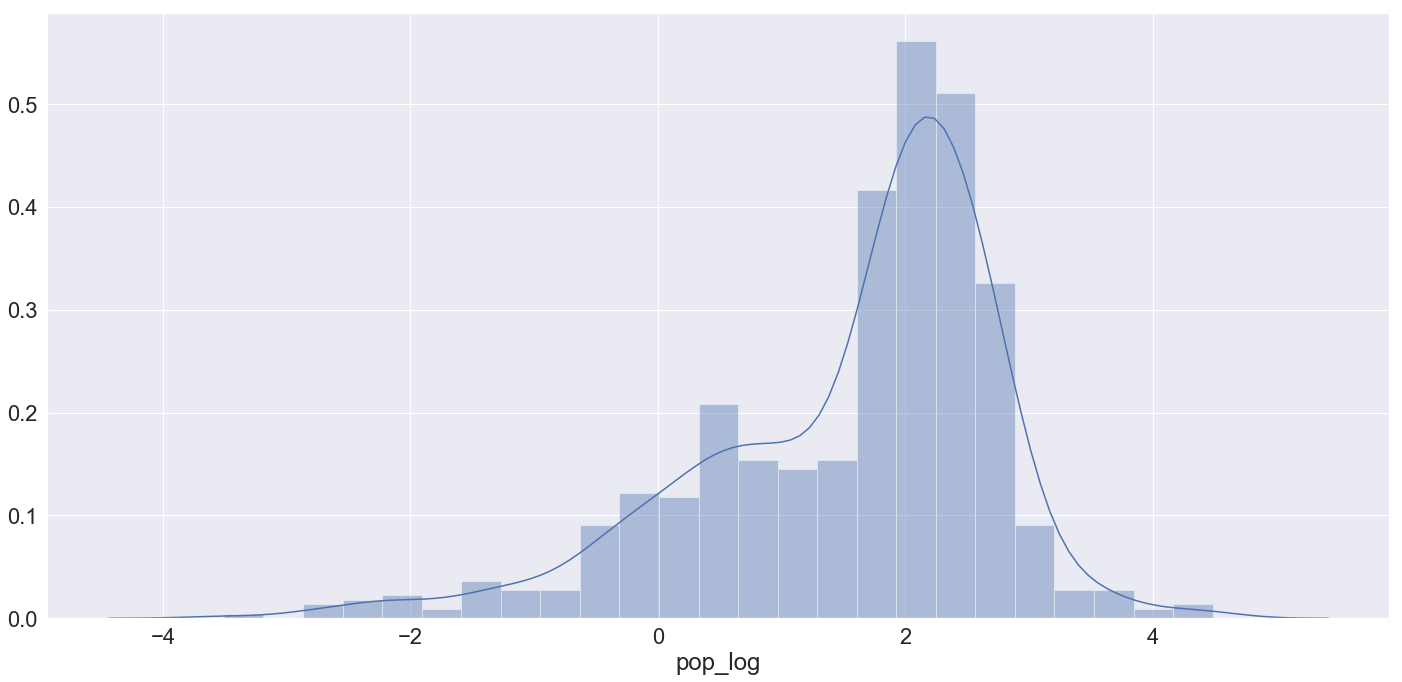

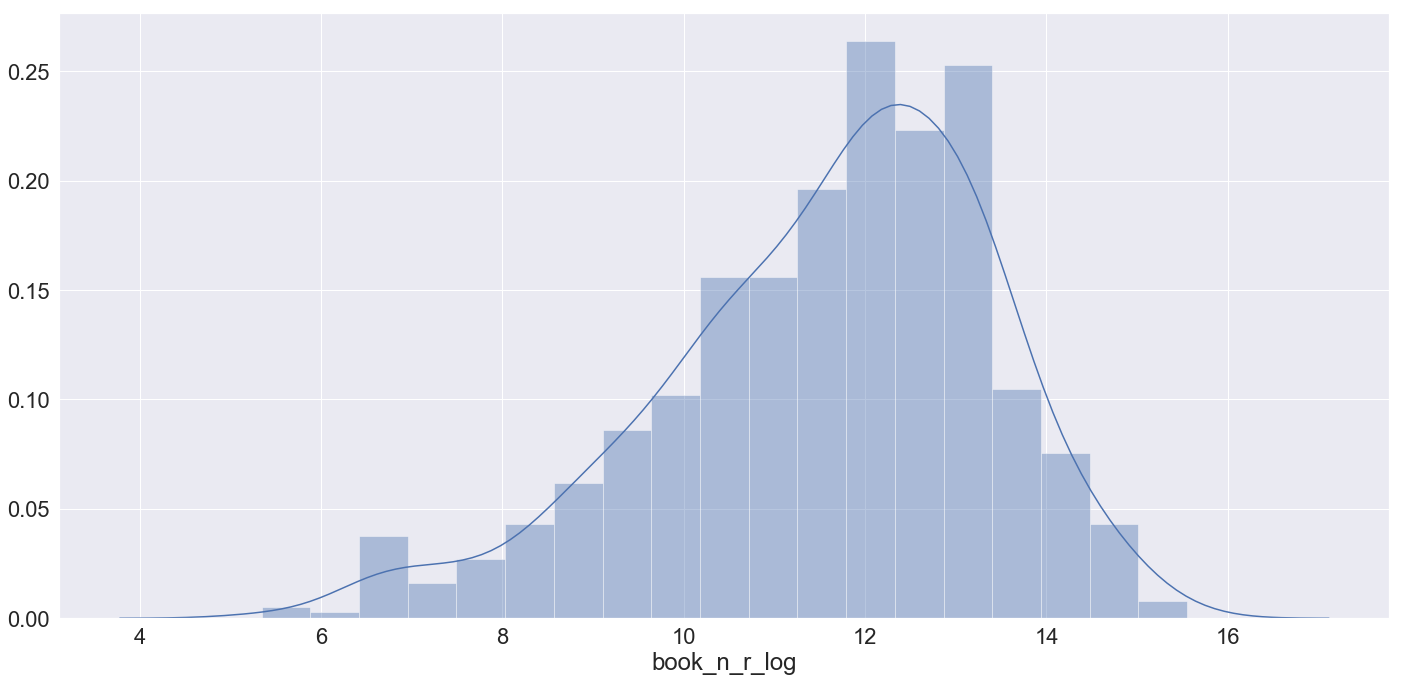

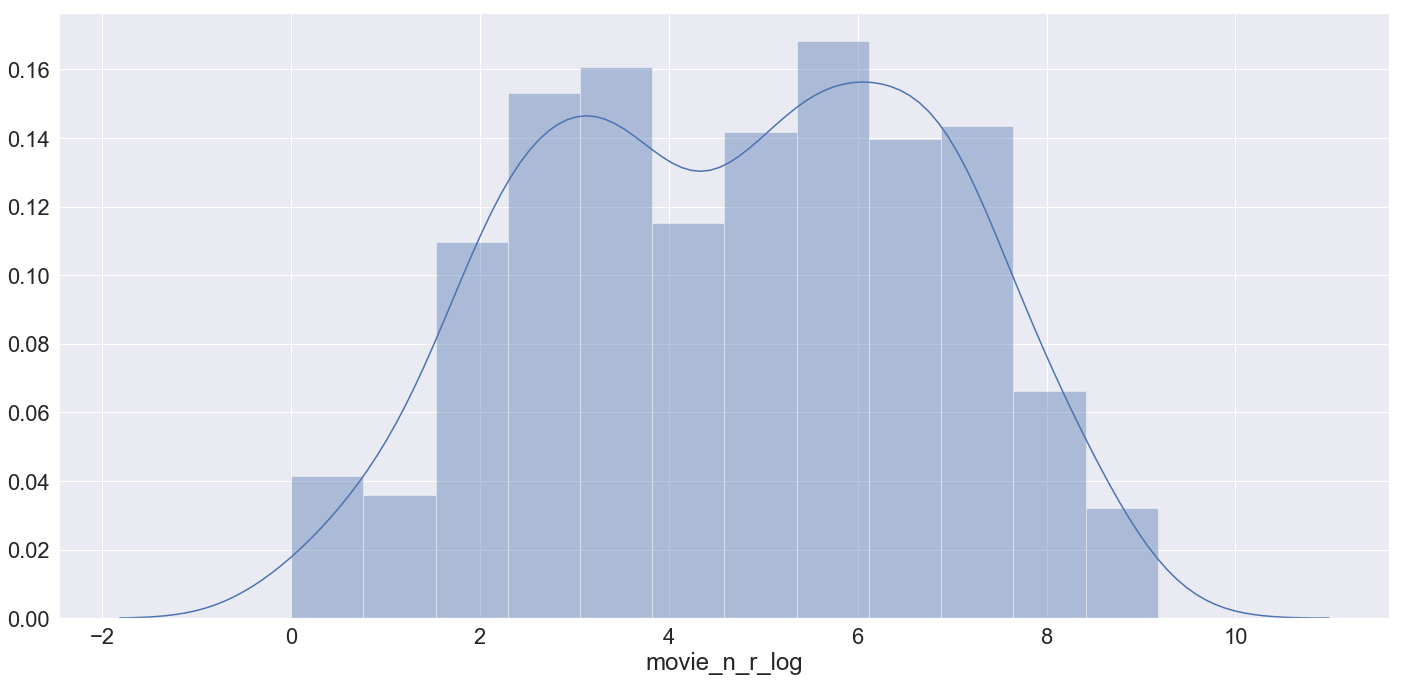

In [103]:
#Now let's plot them again to see the difference:

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns_plot = sns.distplot(book_movie['pop_log'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("pop_log.svg")

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns_plot = sns.distplot(book_movie['book_n_r_log'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("book_n_r_log.svg")

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns_plot = sns.distplot(book_movie['movie_n_r_log'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("movie_n_r_log.svg")

#The results are not perfect but they are closer to a normal distribution than before.

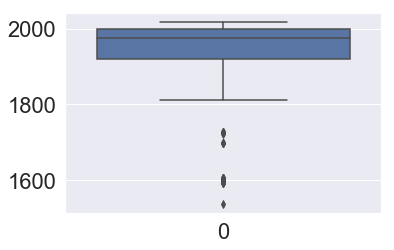

In [104]:
#Looking at the year the book was published, there are a few noticeable outliers:

sns_plot = sns.boxplot(data = book_movie['book_year_published'])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("book_year_published.svg")

In [107]:
date_list = np.array(book_movie['book_year_published'])
q25,q50,q75 = np.percentile(date_list, [25,50,75])
iqr = q75 - q25
minimum = q25 - 1.5*(iqr)
maximum = q75 + 1.5*(iqr)
print(minimum.round(2), q25, q50, q75, maximum.round(2))
print([x for x in book_movie['book_year_published'] if x > maximum])
print([x for x in book_movie['book_year_published'] if x < minimum])

1803.62 1920.25 1975.5 1998.0 2114.62
[]
[1603, 1603, 1697, 1600, 1600, 1593, 1598, 1598, 1600, 1603, 1603, 1593, 1606, 1726, 1697, 1596, 1600, 1606, 1599, 1603, 1595, 1606, 1726, 1595, 1722, 1600, 1603, 1600, 1595, 1536, 1599, 1595, 1599, 1605, 1697, 1595, 1593, 1726, 1697, 1726, 1606, 1605]


In [108]:
#There are a few years where a book was published quite early, before movies even existed, so there are noticeable outliers.
#Let's set these outliers to the max values in the dataset to remove those early values:

book_movie.loc[book_movie.book_year_published < minimum, 'book_year_published'] = np.nan
book_movie.fillna(minimum, inplace = True)

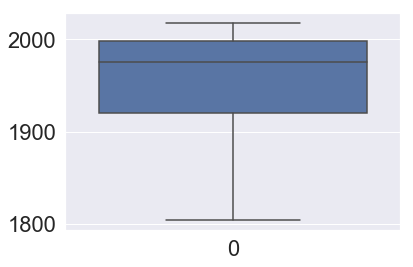

In [109]:
sns.boxplot(data = book_movie['book_year_published'])

In [110]:
book_movie['book_year_pub_or'] = book_movie['book_year_published']

In [111]:
book_movie = book_movie.drop(columns = ['popularity', 'book_number_ratings', 'movie_number_ratings', 'book_year_published'])

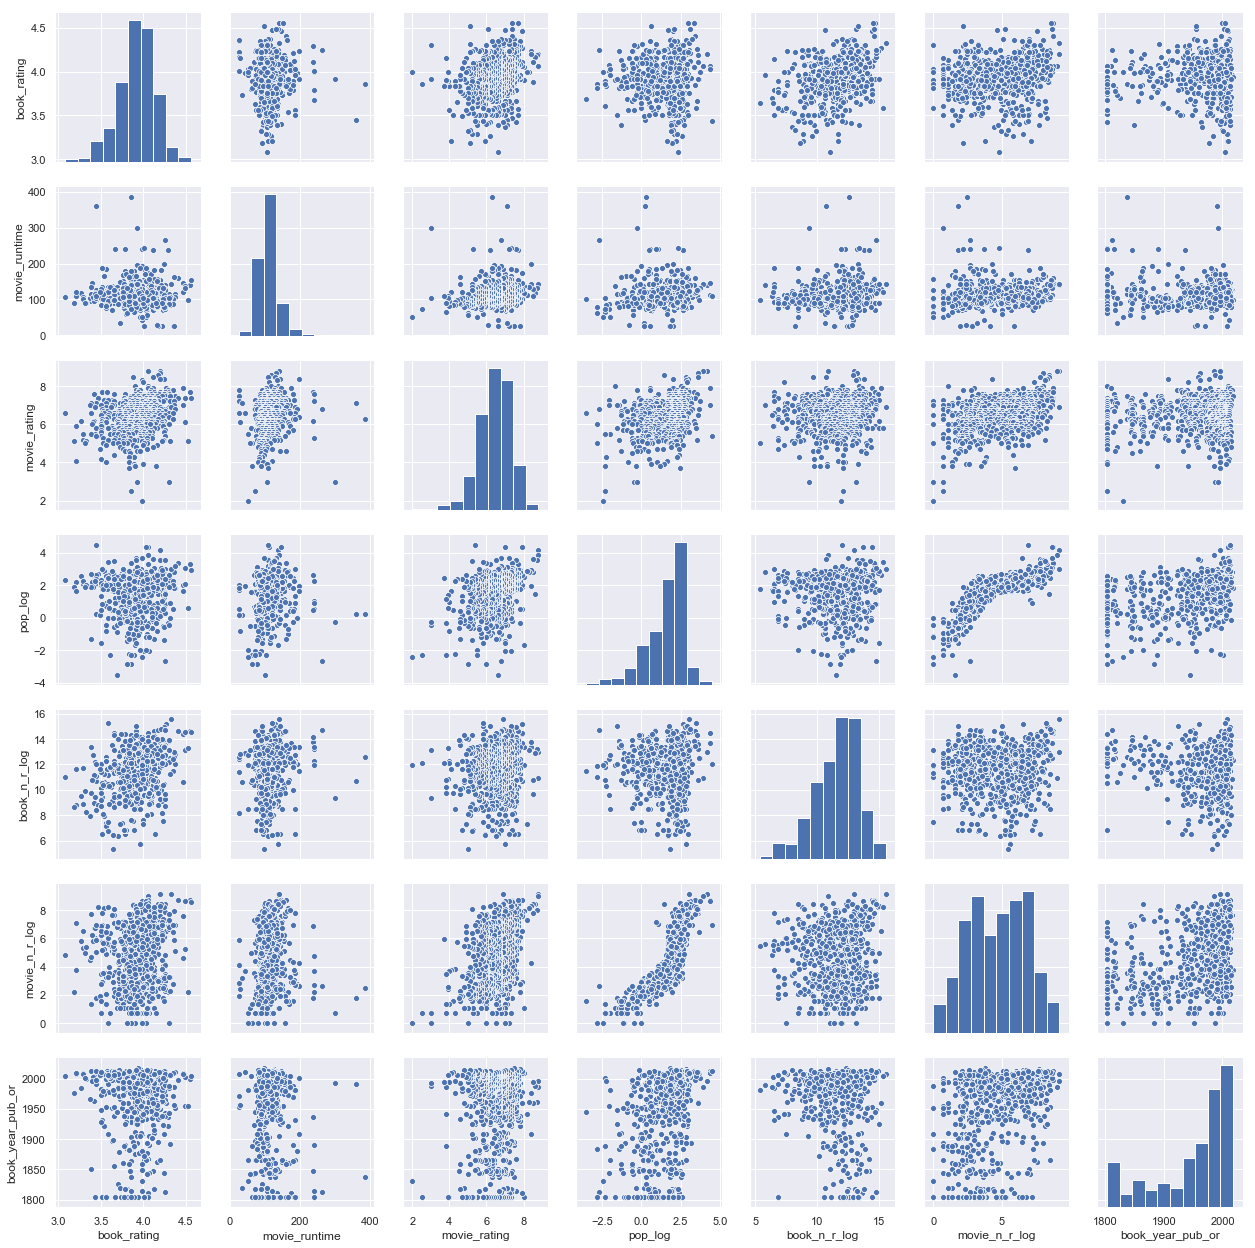

In [112]:
#Now that the features have been transformed, let's examine the pairplot again:
sns.set(font_scale=1) 
sns.pairplot(book_movie)

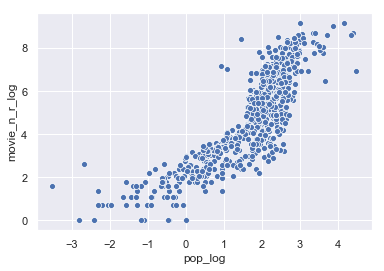

In [113]:
#It looks like the popularity_log and movie_number_ratings_log are candidates for a polynomial tranformation

sns.scatterplot(x = book_movie['pop_log'], y = book_movie['movie_n_r_log'])

In [114]:
book_movie['pop_log'] = book_movie['pop_log']**2

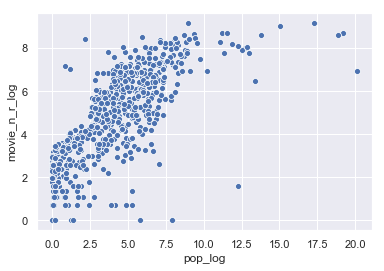

In [115]:
sns.scatterplot(x = book_movie['pop_log'], y = book_movie['movie_n_r_log'])

In [116]:
book_movie.columns

Index(['book_title', 'book_rating', 'release_date', 'movie_runtime', 'genres',
       'movie_rating', 'pop_log', 'book_n_r_log', 'movie_n_r_log',
       'book_year_pub_or'],
      dtype='object')

In [117]:
book_movie = book_movie[['book_title', 'book_rating', 'book_year_pub_or', 'book_n_r_log',
       'genres', 'pop_log', 'release_date', 'movie_runtime','movie_n_r_log', 'movie_rating']]

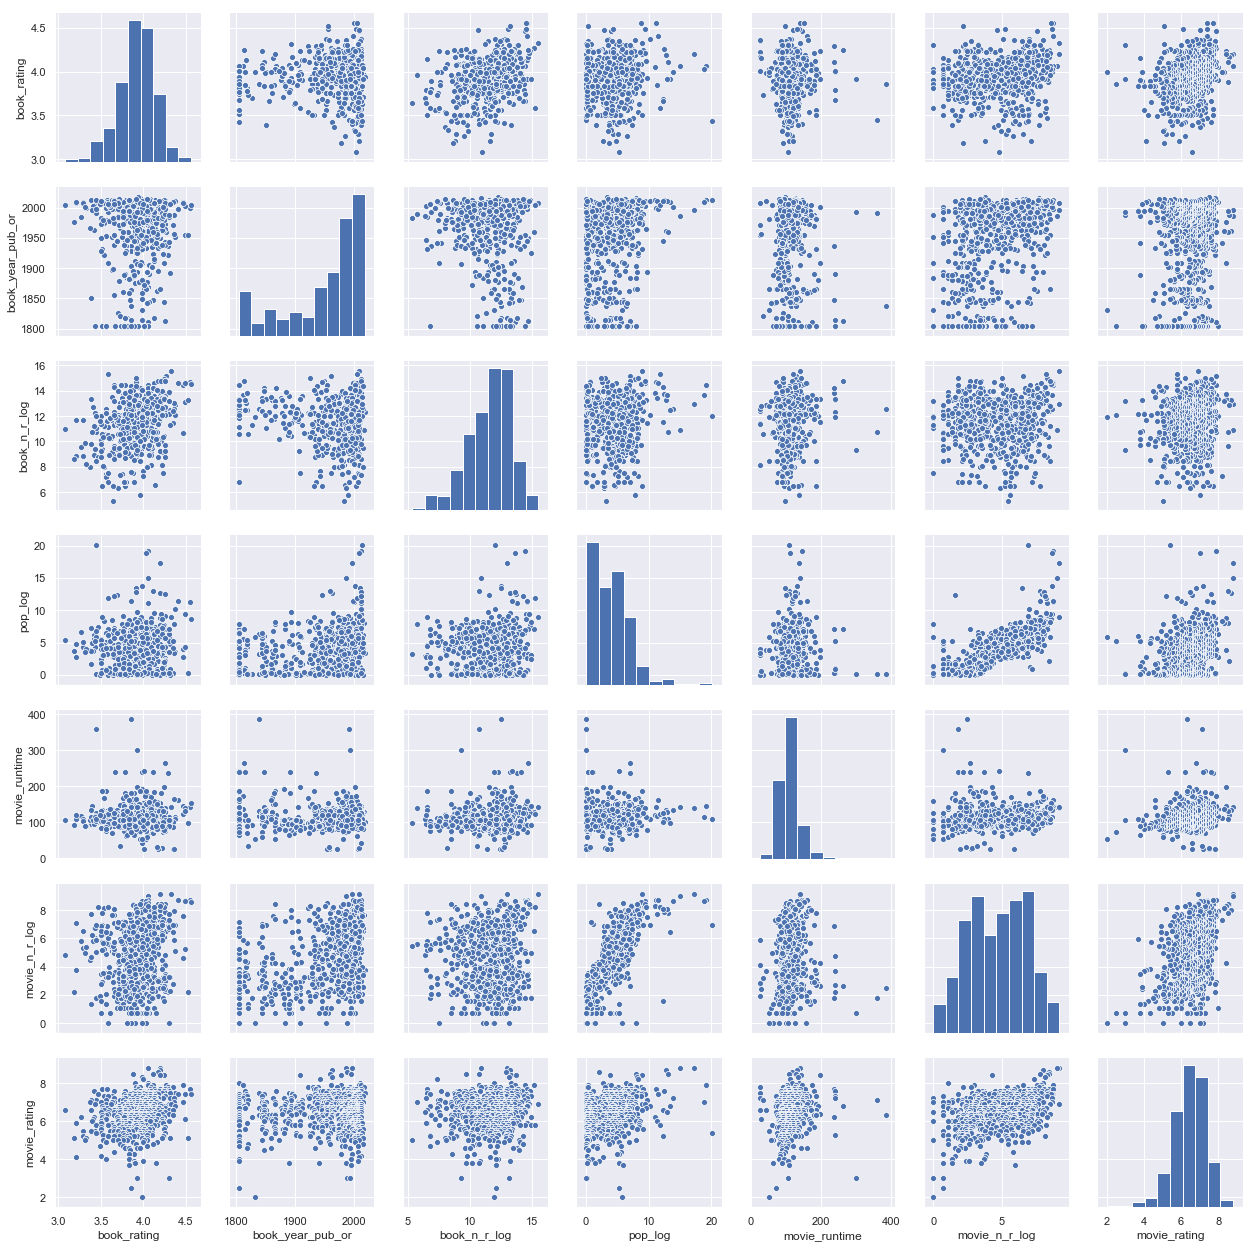

In [118]:
sns.set(font_scale=1) 
sns.pairplot(book_movie)

#After all the feature transformations are completed.

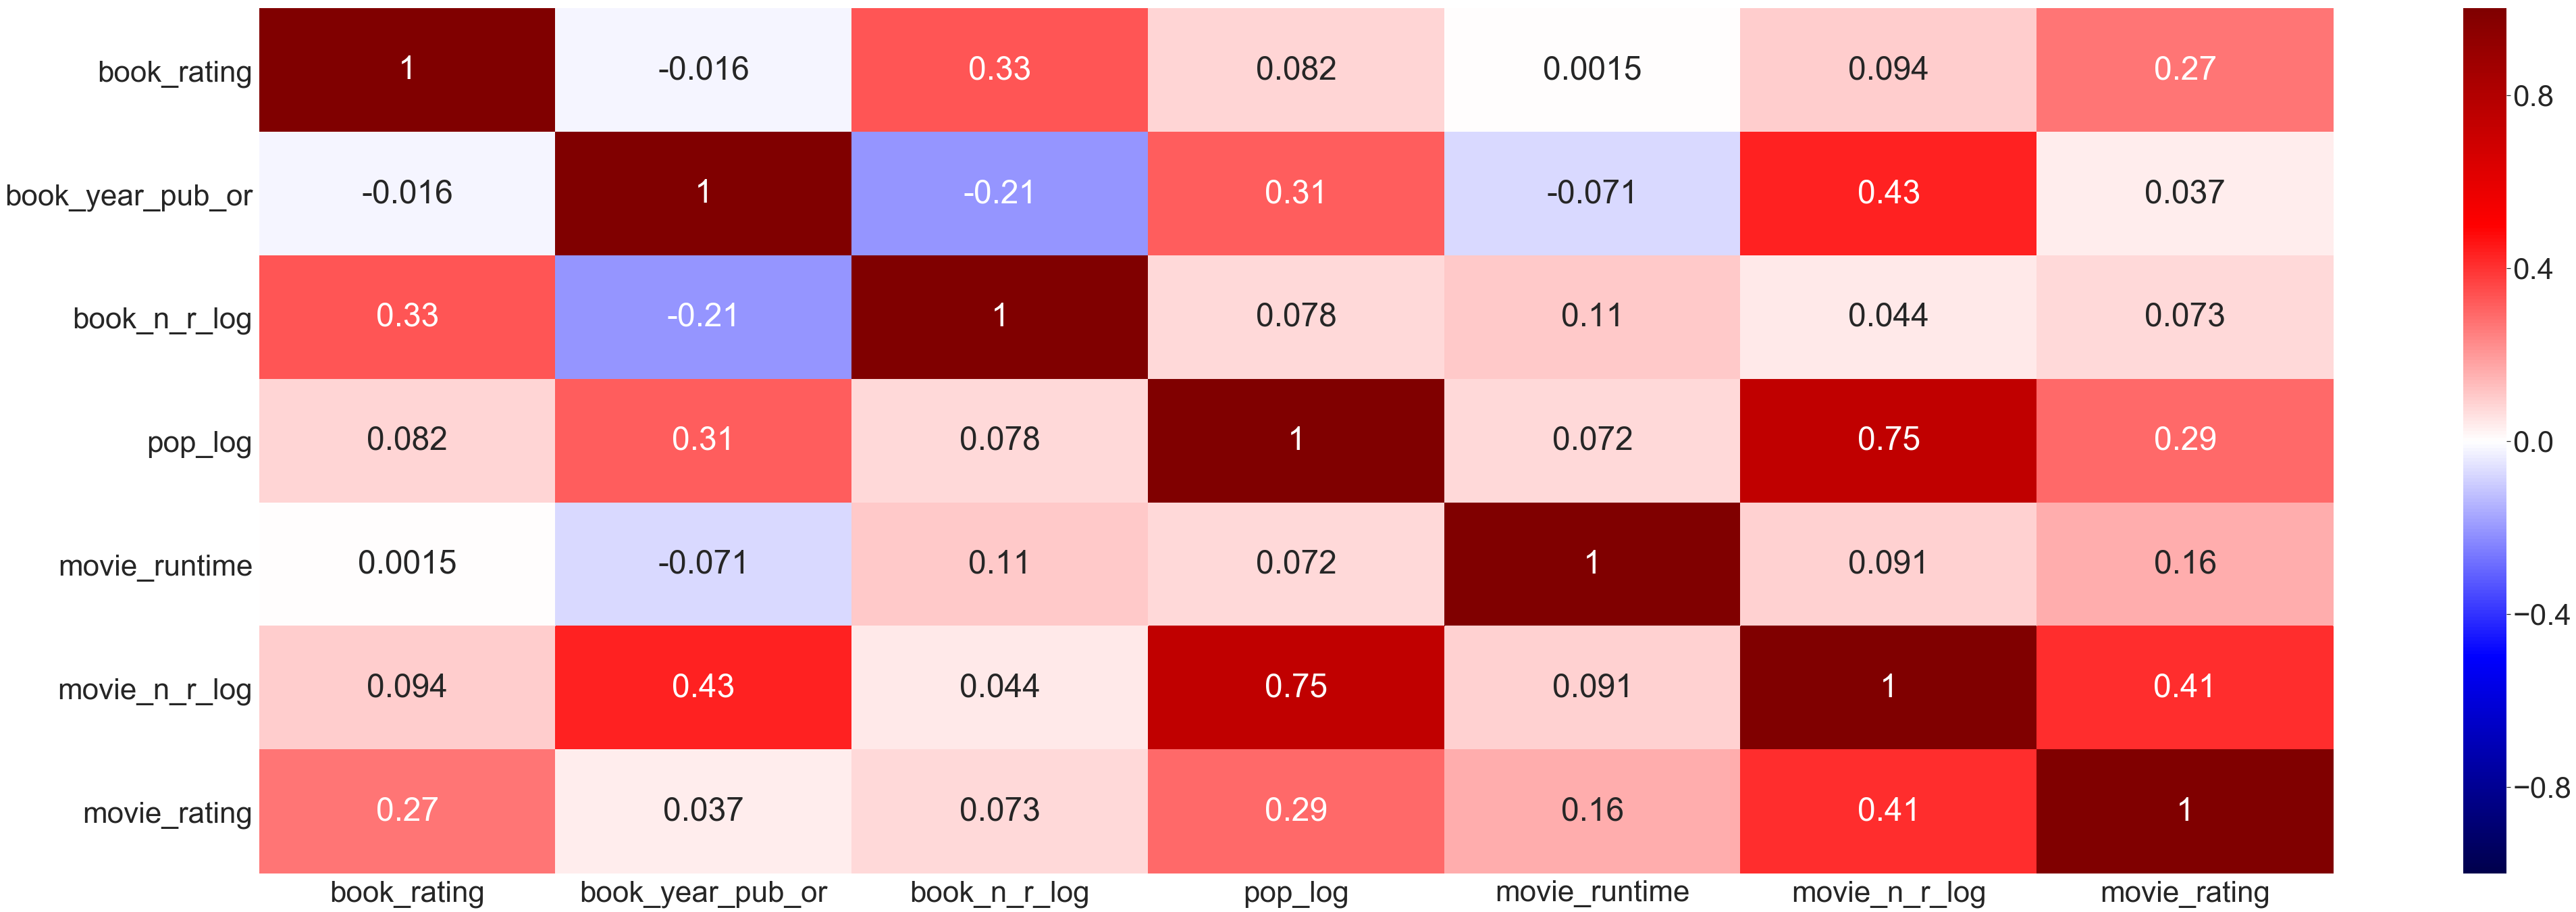

In [251]:
sns.set(font_scale=4) 
plt.figure(figsize=(60,20))
sns_plot = sns.heatmap(book_movie.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("heatmap.svg")

In [276]:
corr_values = book_movie.corr()

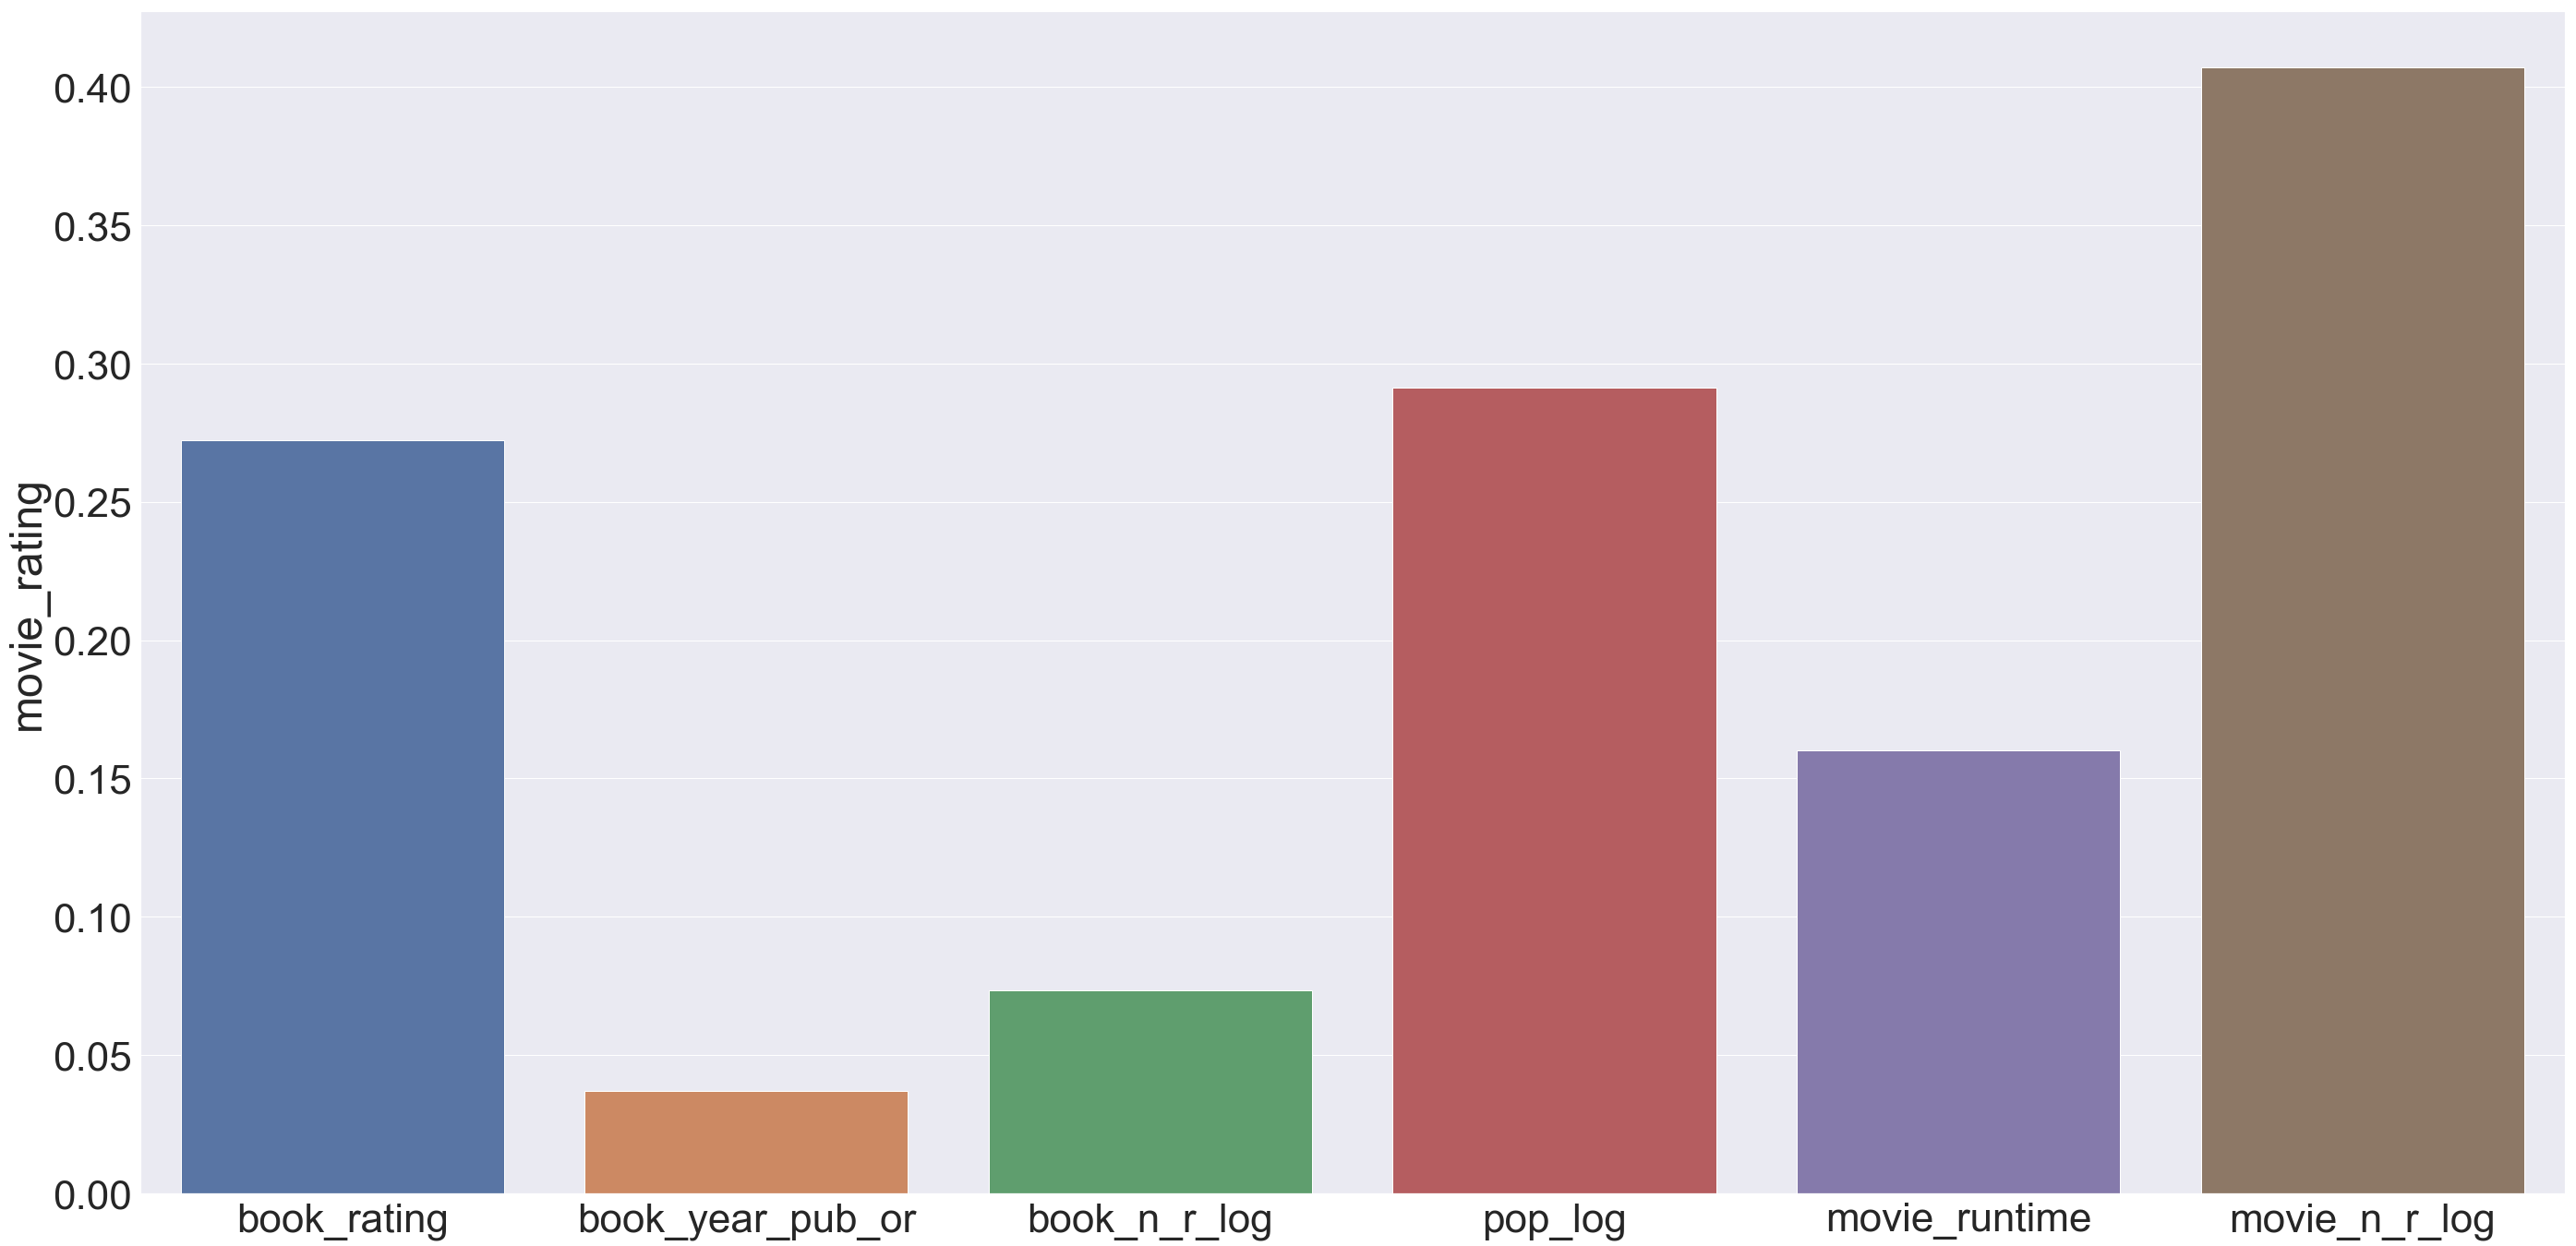

In [289]:
sns.set(font_scale=4) 
plt.figure(figsize=(40,20))

sns_plot = sns.barplot(y = corr_values.iloc[-1][:-1], x = corr_values.index[:-1])
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("movie_corr.svg")

In [120]:
#Using the patsy matrix, examine the relationship between just the book rating and the movie rating.

# Create our feature matrix (X) and target vector (y)
y1, X1 = patsy.dmatrices('movie_rating ~ book_rating', data=book_movie, return_type="dataframe")

# Create the model
model = sm.OLS(y1, X1)

# Fit the model to the training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()


#Not surprisingly, the Adj. R2 is very low but the p-value for the book rating is significant. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           movie_rating   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     55.22
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           3.19e-13
Time:                        10:54:40   Log-Likelihood:                -880.29
No. Observations:                 692   AIC:                             1765.
Df Residuals:                     690   BIC:                             1774.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.1072      0.583      3.614      0.000       0.962       3.252
book_rating     1.1026      0.148      7.431      0.000       0.811       1.394
==============================================================================
Omnibus:                      107.541   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.196
Skew:                          -0.870   Prob(JB):                     2.80e-50
Kurtosis:                       5.210   Cond. No.                         74.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
book_movie.describe()

,book_rating,book_year_pub_or,book_n_r_log,pop_log,movie_runtime,movie_n_r_log,movie_rating
count,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000
mean,3.923150,1949.182442,11.574346,3.896933,112.614162,4.701049,6.432803
std,0.221697,63.611774,1.820360,3.041629,32.189606,2.109893,0.897968
min,3.080000,1803.625000,5.342334,0.000000,25.000000,0.000000,2.000000
25%,3.800000,1920.250000,10.446858,1.131773,95.000000,2.995732,5.900000
50%,3.940000,1975.500000,11.929014,3.865600,107.500000,4.879000,6.500000
75%,4.070000,1998.000000,12.907129,5.686397,125.000000,6.454777,7.000000
max,4.560000,2018.000000,15.552562,20.091232,386.000000,9.177611,8.800000


In [123]:
#Using the patsy matrix, let's repeat the analysis for all the features:

# Create our feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('movie_rating ~ movie_runtime + book_rating + pop_log + book_n_r_log + movie_n_r_log + book_year_pub_or', data=book_movie, return_type="dataframe")

# Create the model
model = sm.OLS(y, X)

# Fit the model to the training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()


#Not surprisingly, the Adj. R2 is higher but still not incredibly high.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           movie_rating   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     39.53
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           2.35e-41
Time:                        10:56:28   Log-Likelihood:                -804.05
No. Observations:                 692   AIC:                             1622.
Df Residuals:                     685   BIC:                             1654.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.9214      1.186      4.993      0.000       3.593       8.250
movie_runtime        0.0032      0.001      3.474      0.001       0.001       0.005
book_rating          1.0234      0.142      7.204      0.000       0.744       1.302
pop_log             -0.0092      0.015     -0.630      0.529      -0.038       0.020
book_n_r_log        -0.0365      0.018     -2.040      0.042      -0.072      -0.001
movie_n_r_log        0.1989      0.022      8.912      0.000       0.155       0.243
book_year_pub_or    -0.0022      0.001     -4.165      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       62.589   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.061
Skew:                          -0.634   Prob(JB):                     3.08e-22
Kurtosis:                       4.352   Cond. No.                     7.85e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Residuals')

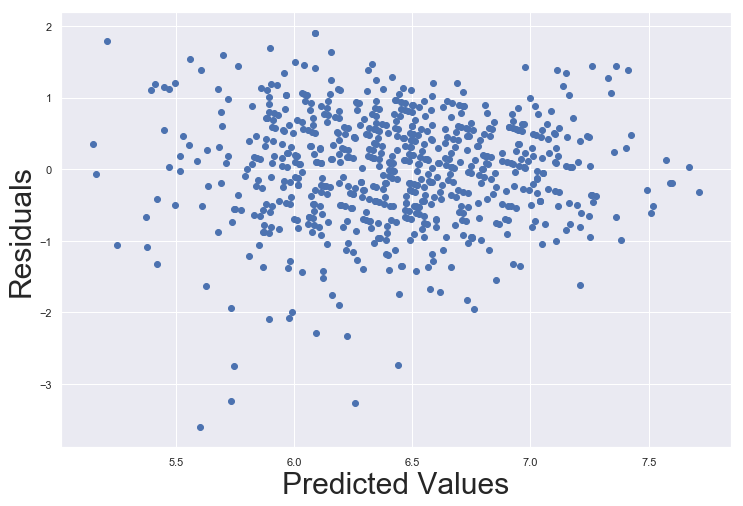

In [124]:
sns.set(font_scale=1) 
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);
plt.xlabel('Predicted Values', size = 30)
plt.ylabel('Residuals', size = 30)

```
standard scaler
coeff will change but model will remain the same
before doing this, split into training, validation and testing
then do regularization to choose features to take and to keep, split into training, validation, and testing set.
turn into a better model
worsens R2 in sample but then makes a better general model.
```

In [27]:
#Splitting the data into training, validation, and testing (60-20-20)

In [125]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [126]:
X_train.columns

Index(['Intercept', 'movie_runtime', 'book_rating', 'pop_log', 'book_n_r_log',
       'movie_n_r_log', 'book_year_pub_or'],
      dtype='object')

In [136]:
#Scaling the features 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_ridge = Ridge(alpha = 100)

In [137]:
X_train_scaled.shape

(414, 7)

In [138]:
X_val_scaled.shape

(139, 7)

In [139]:
X_test_scaled.shape

(139, 7)

In [140]:
lm_ridge.fit(X_train_scaled, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [141]:
lm_ridge.score(X_val_scaled, y_val)

0.304943372434197

In [142]:
lm_ridge.fit(X,y)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [143]:
lm_ridge.score(X_test_scaled, y_test)

-3.753748894881266

In [144]:
y_predict = lm_ridge.predict(X_test_scaled)

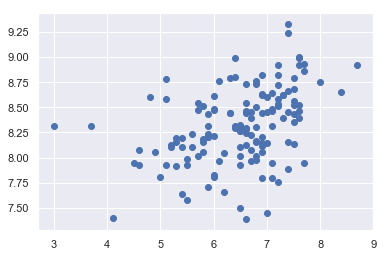

In [145]:
sns.set(font_scale=1) 
plt.scatter(y_test, y_predict)

In [146]:
coeffs = lm_ridge.coef_
intercept =  lm_ridge.intercept_
# print the coefficients
print(intercept)
print(book_movie.columns)
print(coeffs)

[8.31687846]
Index(['book_title', 'book_rating', 'book_year_pub_or', 'book_n_r_log',
       'genres', 'pop_log', 'release_date', 'movie_runtime', 'movie_n_r_log',
       'movie_rating'],
      dtype='object')
[[ 0.          0.00308089  0.2369207  -0.00238424 -0.00336432  0.18984255
  -0.00205457]]


In [147]:
np.sqrt(metrics.mean_squared_error(y_test, y_predict))

2.0244311676507056

In [148]:
X_test_scaled.shape

(139, 7)

In [149]:
y_test.shape

(139, 1)

In [150]:
#import scipy.stats as stats
residuals = lm_ridge.predict(X_test_scaled) - y_test
#stats.probplot(log_resid, dist='norm', plot = plt)
#plt.show()

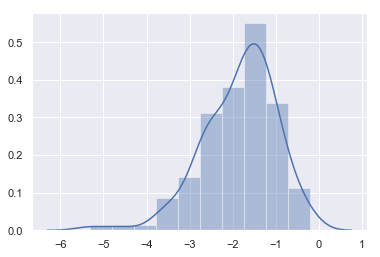

In [151]:
sns.set(font_scale=1) 
sns.distplot((y_test-y_predict),bins=10);

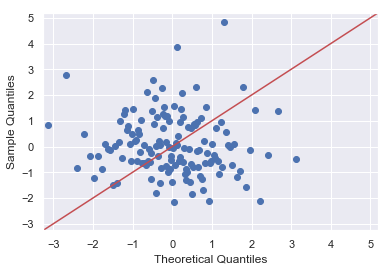

In [152]:
sns.set(font_scale=1) 
fig = sm.qqplot(residuals, stats.t, fit = True, line = '45')
plt.show()

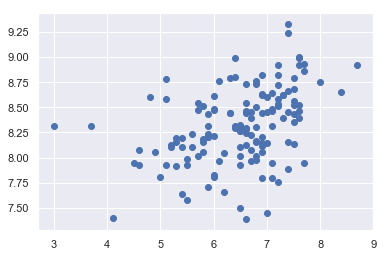

In [153]:
sns.set(font_scale=1) 
plt.scatter(y_test,y_predict)

In [270]:
#Exploratory data analysis to dig into the data:

In [154]:
book_movie.sort_values(by = 'book_rating', ascending = False).head(5)

,book_title,book_rating,book_year_pub_or,book_n_r_log,genres,pop_log,release_date,movie_runtime,movie_n_r_log,movie_rating
92,Harry Potter and the Half-Blood Prince,4.56,2005.0,14.543911,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8.694482,"Tuesday, July 7, 2009",153,8.600615,7.4
32,Harry Potter and the Prisoner of Azkaban,4.55,1999.0,14.656022,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",11.212450,"Monday, May 31, 2004",141,8.705662,7.7
642,The Return of the King,4.52,1955.0,13.275620,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",0.345493,"Sunday, May 11, 1980",98,2.197225,5.1
90,Harry Potter and the Order of the Phoenix,4.49,2003.0,14.568637,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",9.372905,"Thursday, June 28, 2007",138,8.636397,7.4
462,The Lord of the Rings,4.49,1955.0,13.111509,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",4.277153,"Wednesday, November 15, 1978",132,5.231109,6.1


In [155]:
book_movie.sort_values(by = 'movie_rating', ascending = False).head(5)

,book_title,book_rating,book_year_pub_or,book_n_r_log,genres,pop_log,release_date,movie_runtime,movie_n_r_log,movie_rating
0,Fight Club,4.20,1996.0,12.983085,"[{'id': 18, 'name': 'Drama'}]",17.279400,"Friday, October 15, 1999",139,9.177611,8.8
1,Forrest Gump,4.06,1986.0,10.918392,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",15.036081,"Wednesday, July 6, 1994",142,9.005405,8.8
2,One Flew Over the Cuckoo's Nest,4.19,1962.0,13.231264,"[{'id': 18, 'name': 'Drama'}]",12.747595,"Tuesday, November 18, 1975",133,8.006701,8.7
3,The Silence of the Lambs,4.17,1988.0,12.909140,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",2.134340,"Friday, February 1, 1991",119,8.422663,8.6
4,Psycho,4.11,1959.0,10.739175,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",13.005492,"Thursday, June 16, 1960",109,7.785305,8.5


In [28]:
top_five_books = book_movie.sort_values(by = 'book_rating', ascending = False).head(5)

In [29]:
top_ten_books = book_movie.sort_values(by = 'book_rating', ascending = False).head(10)

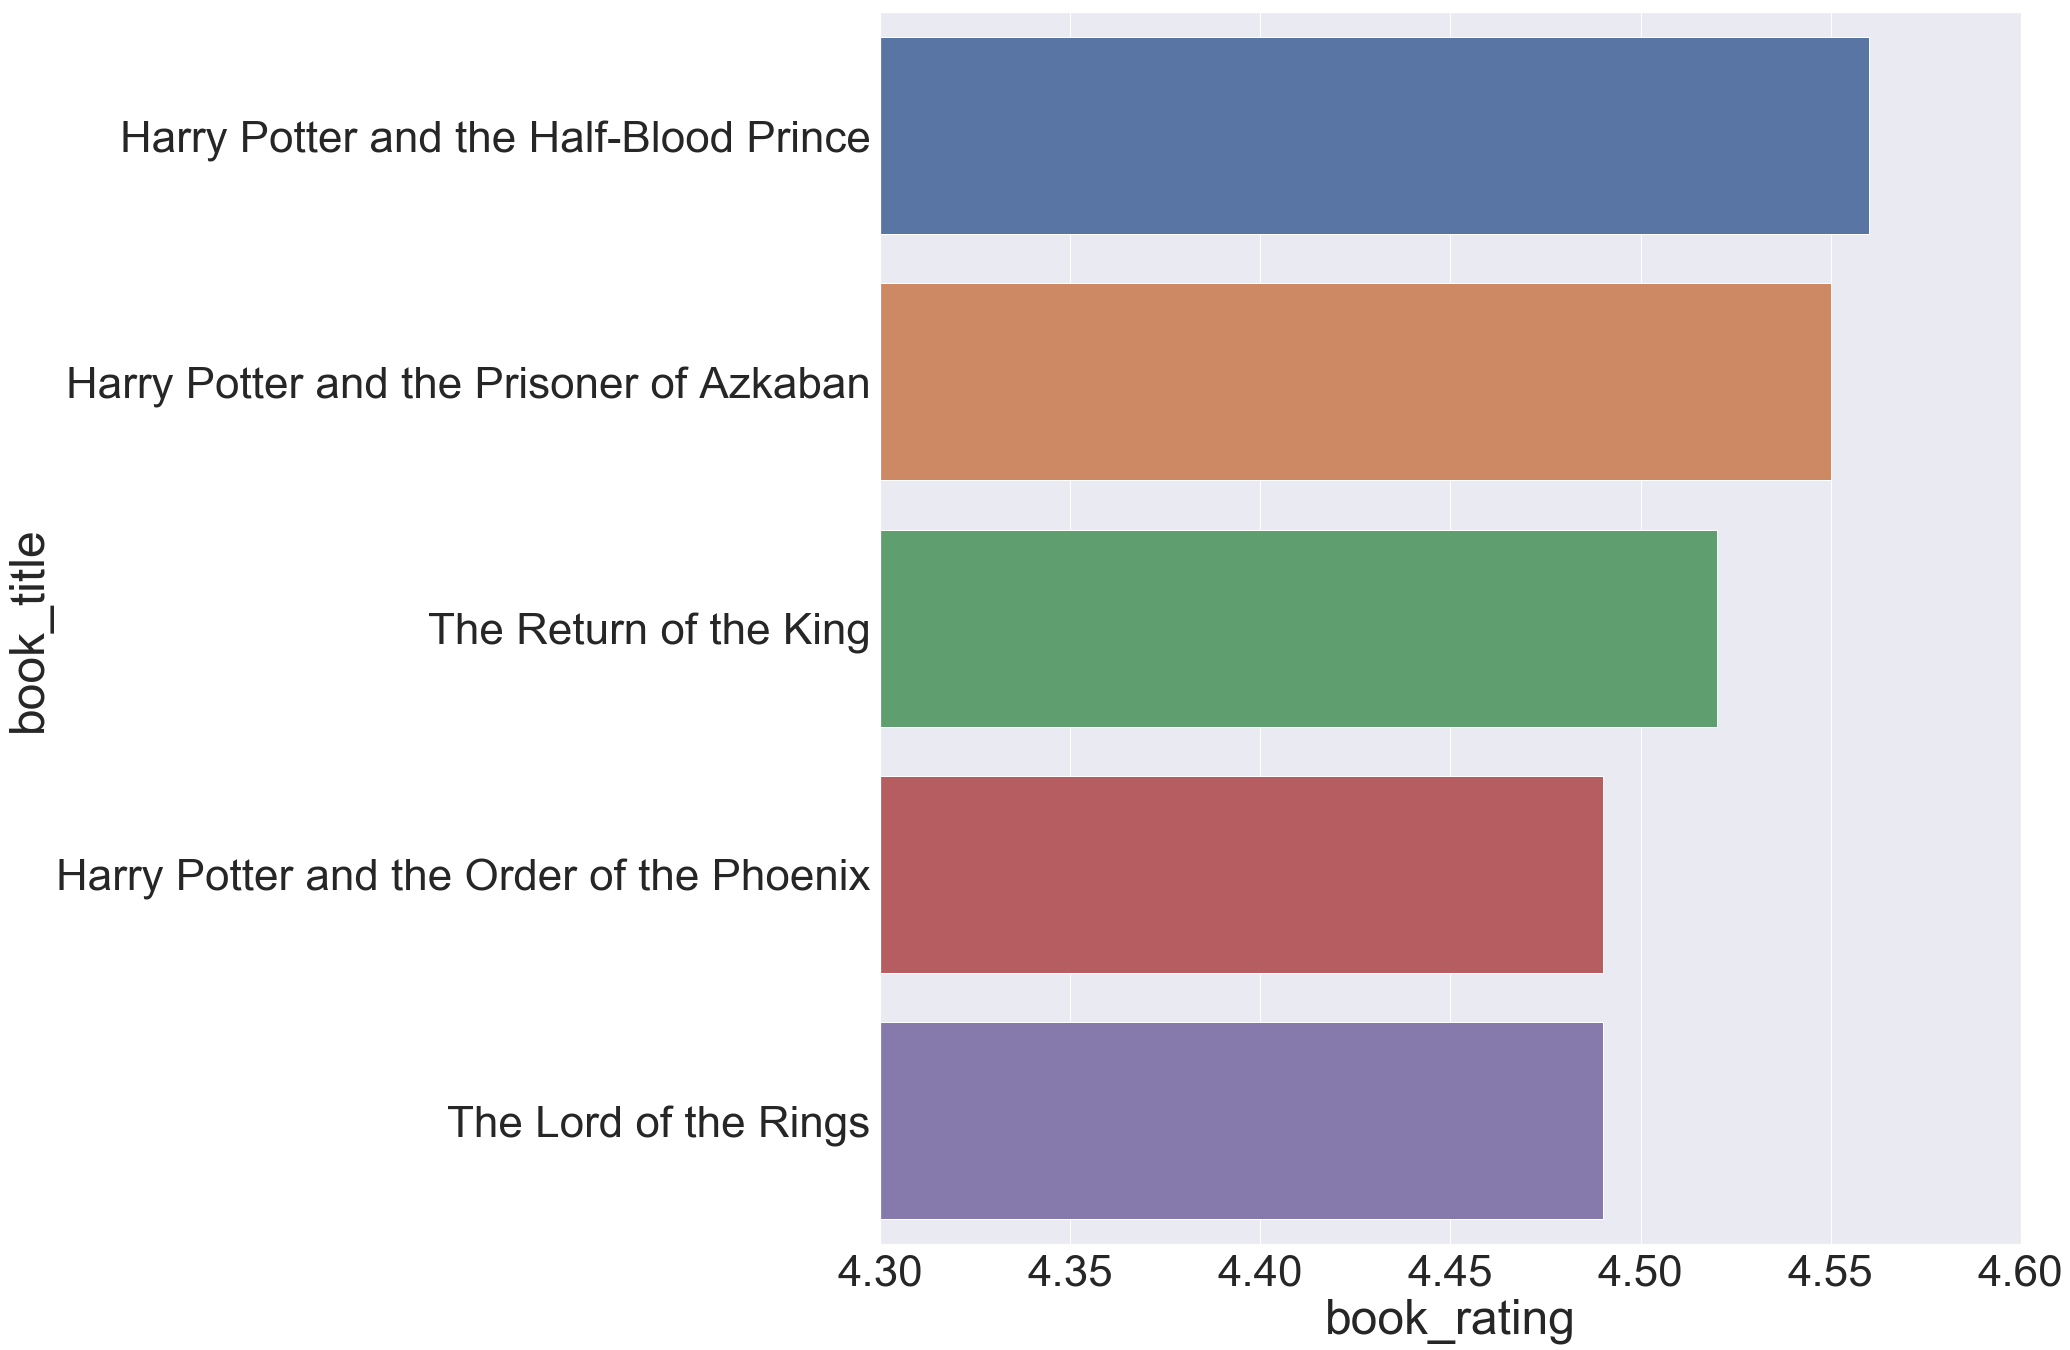

In [30]:
sns.set(font_scale=4) 
plt.figure(figsize=(30,20))
sns_plot = sns.barplot(y = 'book_title', x = 'book_rating', data = top_five_books)
plt.xlim(4.3, 4.6)
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("top_five_books.svg")

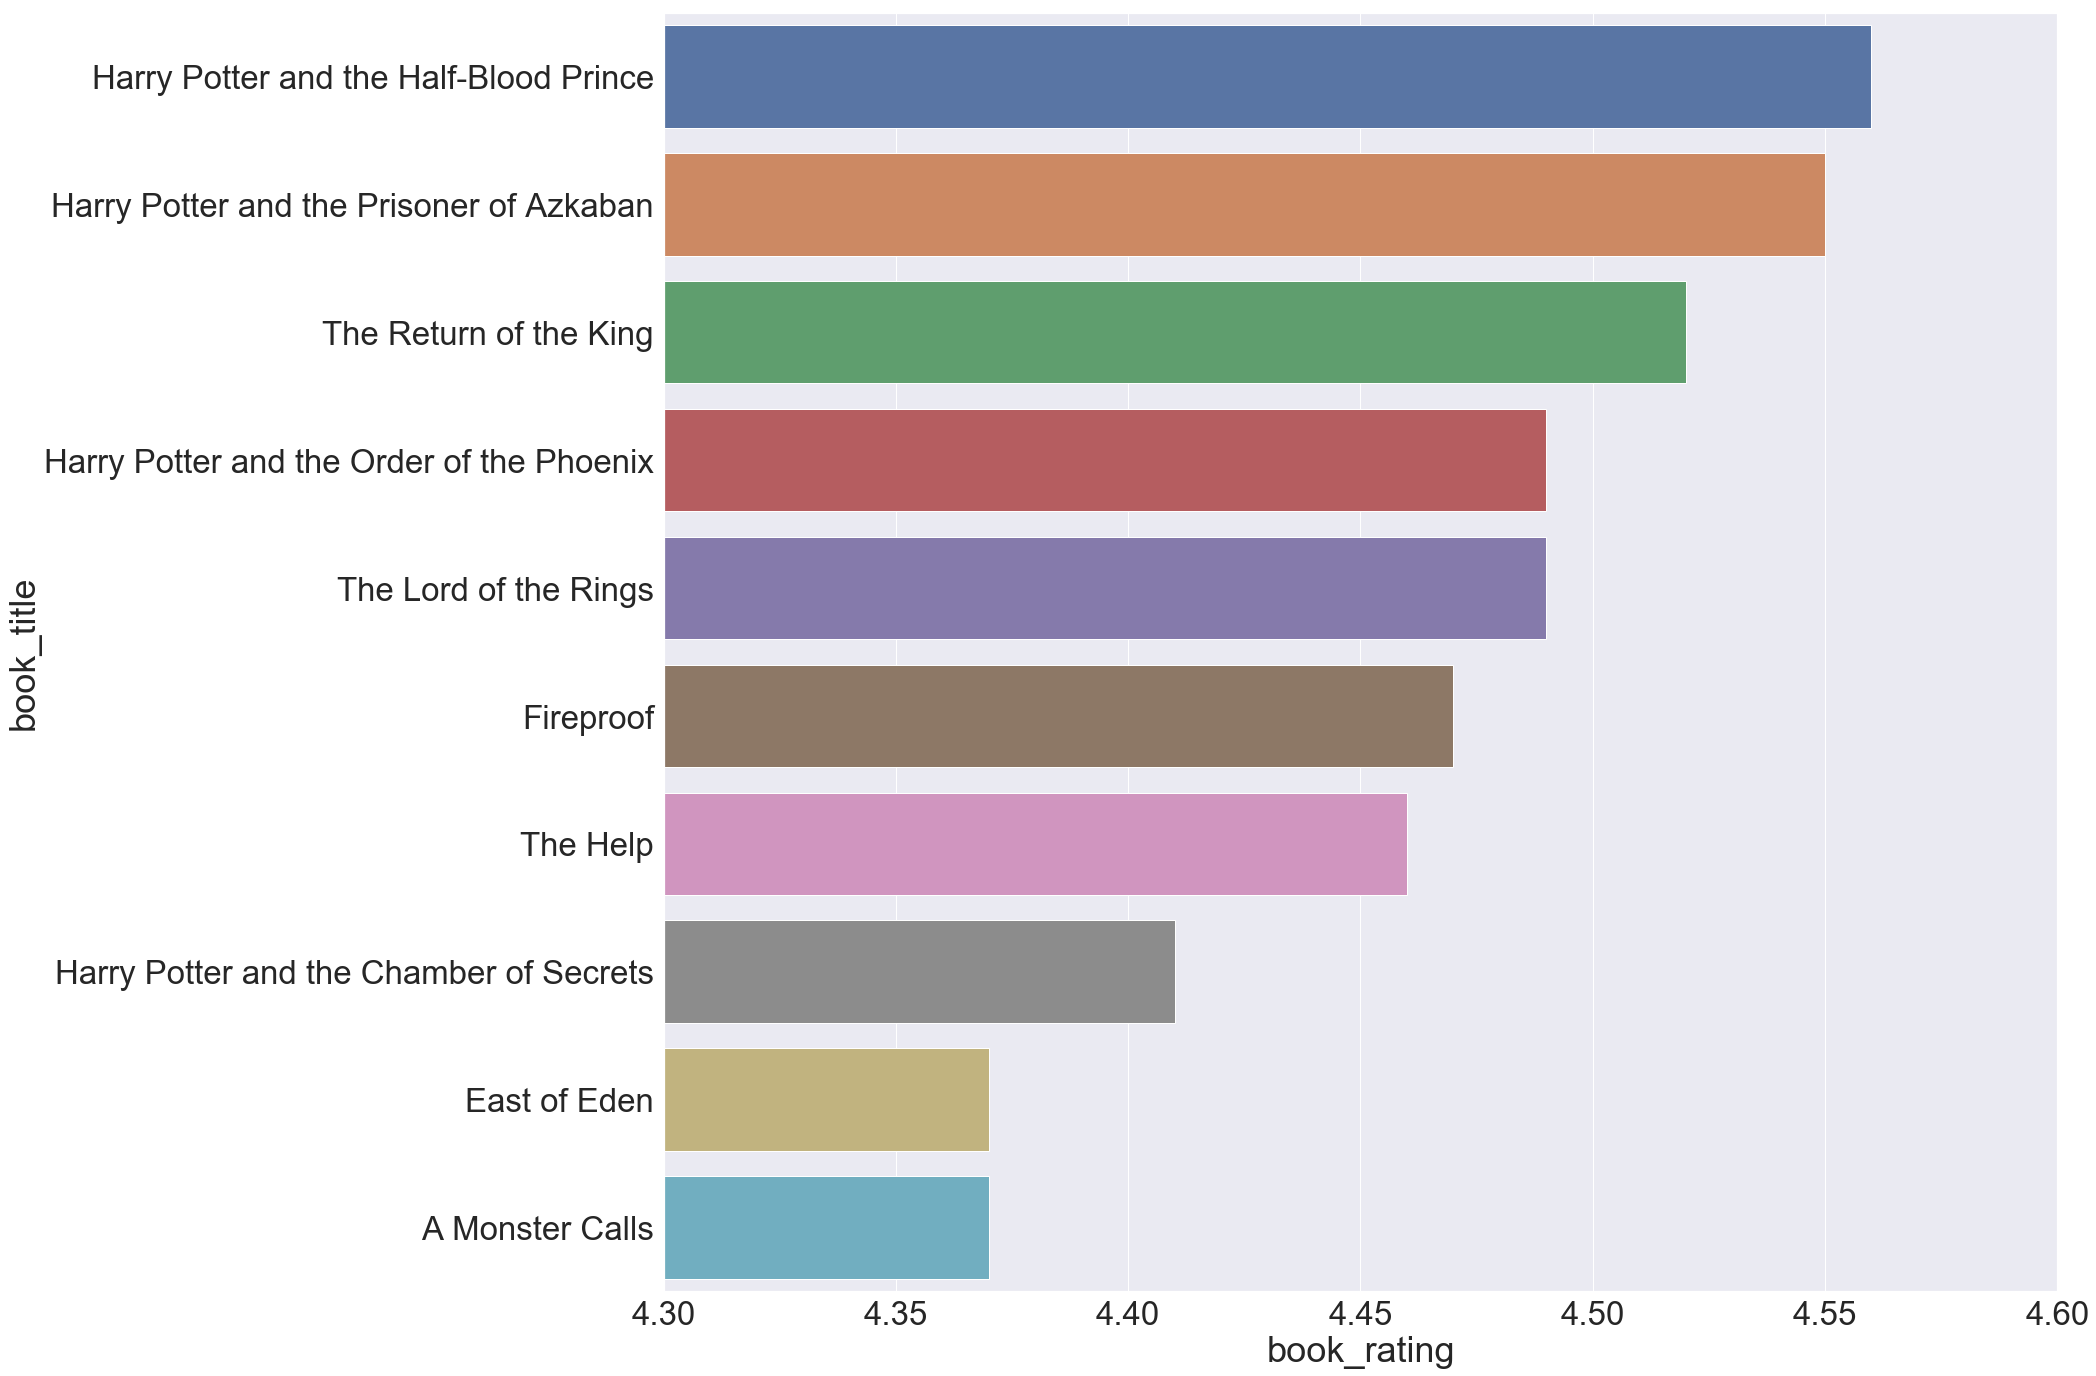

In [159]:
sns.set(font_scale=3) 
plt.figure(figsize=(30,20))
sns_plot = sns.barplot(y = 'book_title', x = 'book_rating', data = top_ten_books)
plt.xlim(4.3, 4.6)
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("top_ten_books.svg")

In [32]:
top_five_movies = book_movie.sort_values(by = 'movie_rating', ascending = False).head(5)

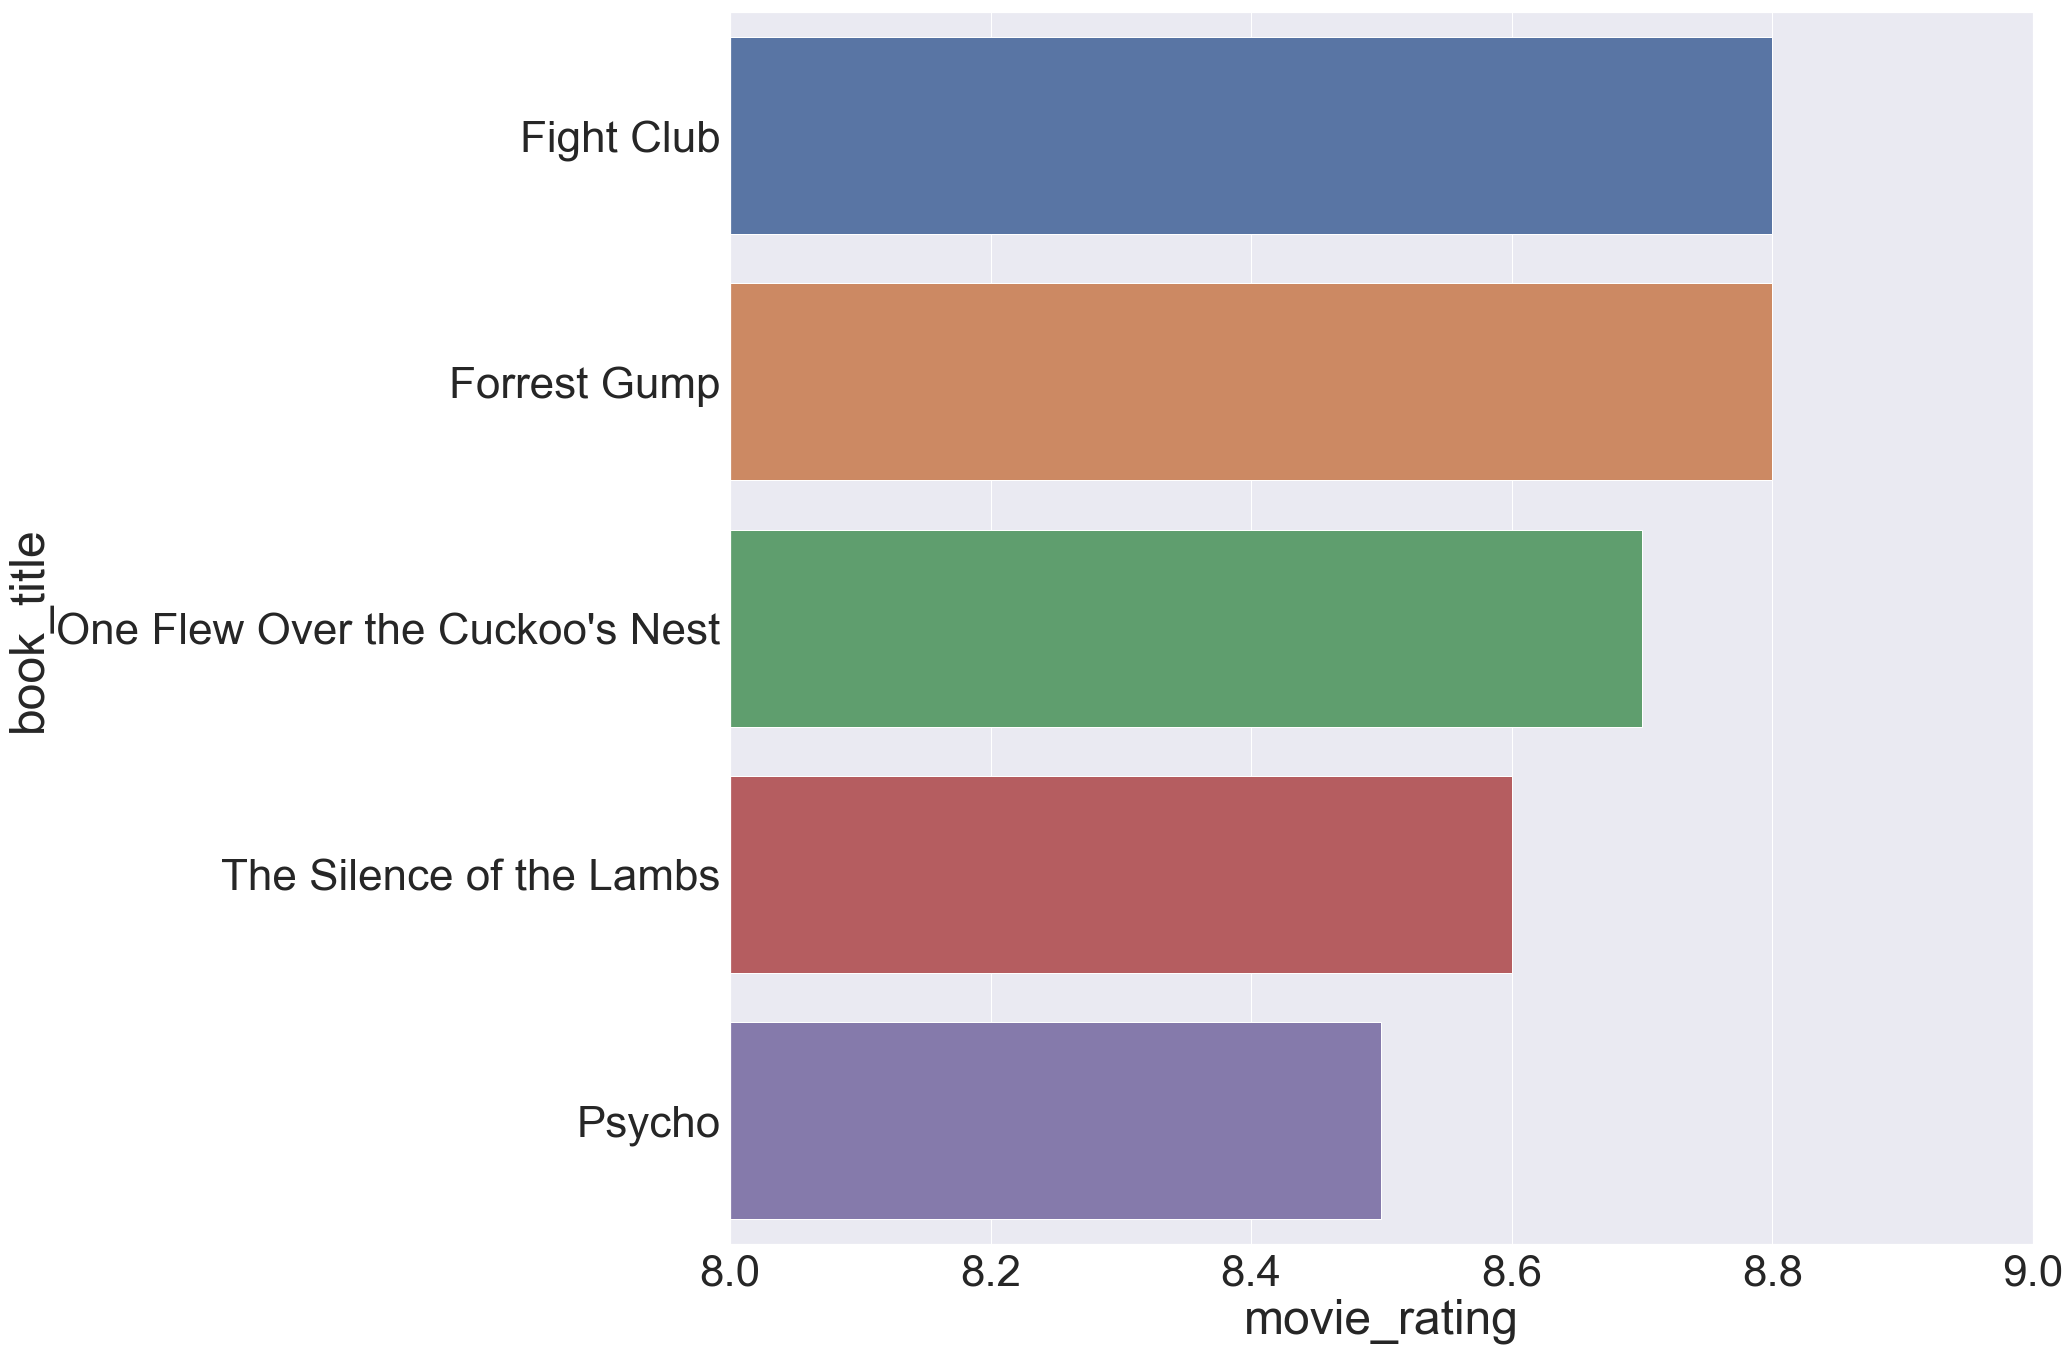

In [33]:
sns.set(font_scale=4) 
plt.figure(figsize=(30,20))
sns_plot = sns.barplot(y = 'book_title', x = 'movie_rating', data = top_five_movies)
plt.xlim(8, 9)
plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("top_five_movies.svg")

In [162]:
top_ten_movies = book_movie.sort_values(by = 'movie_rating', ascending = False).head(10)

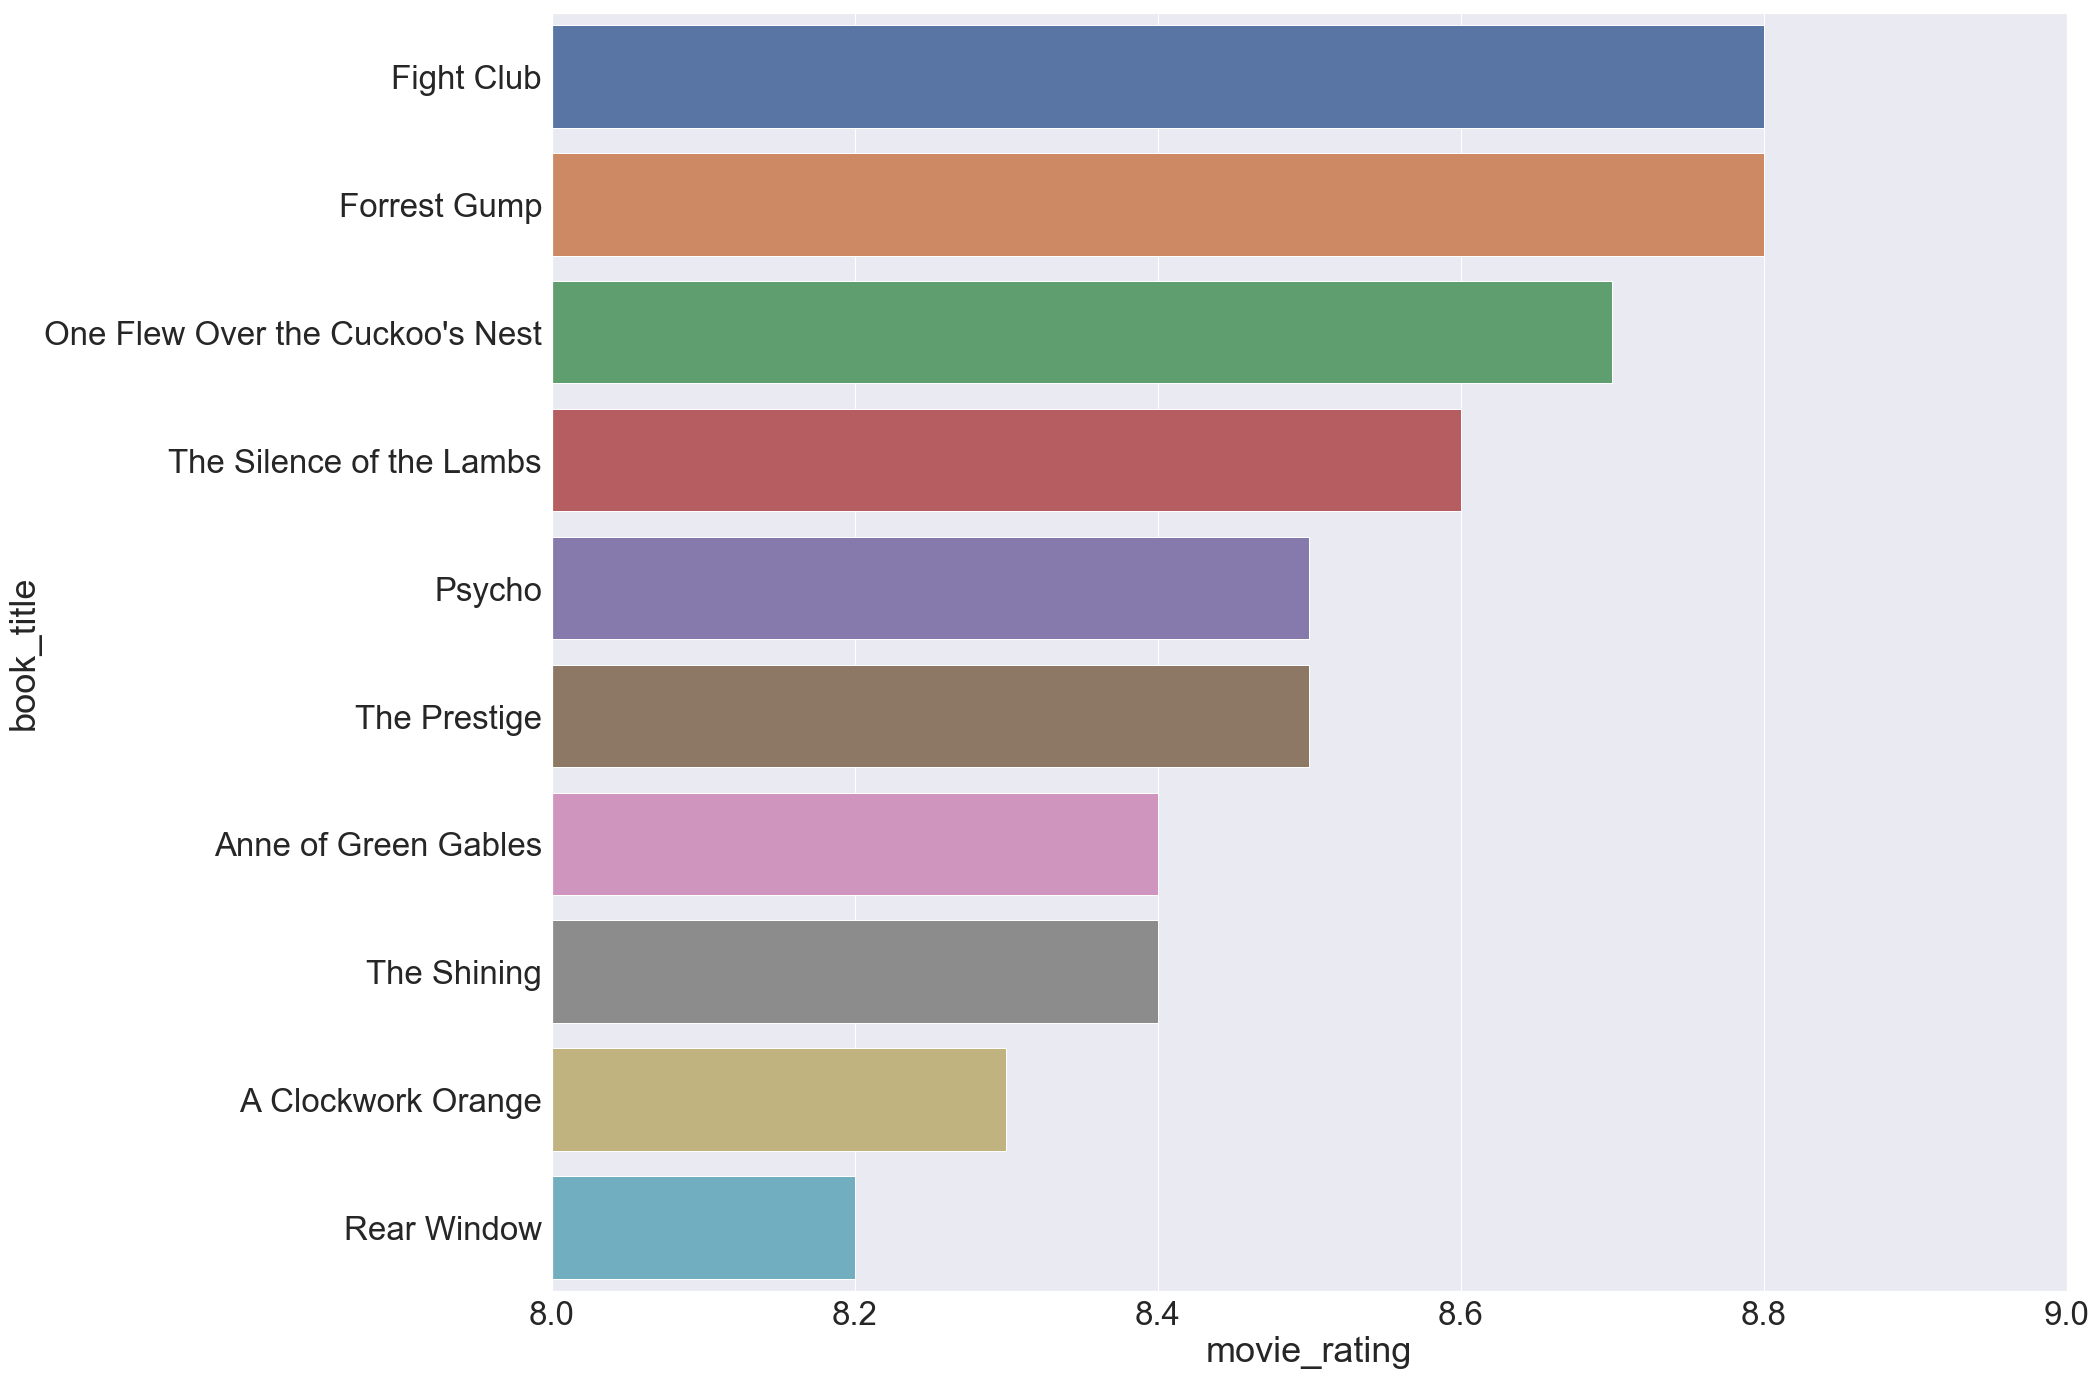

In [163]:
sns.set(font_scale=3) 
plt.figure(figsize=(30,20))
sns_plot = sns.barplot(y = 'book_title', x = 'movie_rating', data = top_ten_movies)
plt.xlim(8, 9)

plt.tight_layout()
fig = sns_plot.get_figure()
fig.savefig("top_ten_movies.svg")

In [164]:
bottom_ten_movies = book_movie.sort_values(by = 'movie_rating', ascending = True).head(10)

In [166]:
bottom_ten_books = book_movie.sort_values(by = 'book_rating', ascending = True).head(10)

In [40]:
top_50_books = book_movie.sort_values(by = 'book_rating', ascending = False).head(50)
top_50_books

,book_title,book_rating,book_number_ratings,book_year_published,popularity,release_date,movie_runtime,movie_number_ratings,genres,movie_rating
92,Harry Potter and the Half-Blood Prince,4.56,2071765,2005,19.08,"Tuesday, July 7, 2009",153,5435,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.4
32,Harry Potter and the Prisoner of Azkaban,4.55,2317552,1999,28.46,"Monday, May 31, 2004",141,6037,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.7
642,The Return of the King,4.52,582812,1955,1.80,"Sunday, May 11, 1980",98,9,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",5.1
90,Harry Potter and the Order of the Phoenix,4.49,2123629,2003,21.36,"Thursday, June 28, 2007",138,5633,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.4
462,The Lord of the Rings,4.49,494602,1955,7.91,"Wednesday, November 15, 1978",132,187,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",6.1
204,Fireproof,4.47,42088,2008,5.33,"Friday, September 26, 2008",122,100,"[{'id': 18, 'name': 'Drama'}]",7.0
16,The Help,4.46,1858781,2009,7.49,"Tuesday, August 9, 2011",146,1966,"[{'id': 18, 'name': 'Drama'}]",7.9
86,Harry Potter and the Chamber of Secrets,4.41,2269371,1998,29.74,"Wednesday, November 13, 2002",161,5966,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.4
59,East of Eden,4.37,378558,1952,6.43,"Wednesday, March 9, 1955",115,163,"[{'id': 18, 'name': 'Drama'}]",7.5
266,A Monster Calls,4.37,170896,2011,24.48,"Friday, October 7, 2016",108,1023,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",6.8


In [19]:
top_50_movies = book_movie.sort_values(by = 'movie_rating', ascending = False).head(50)

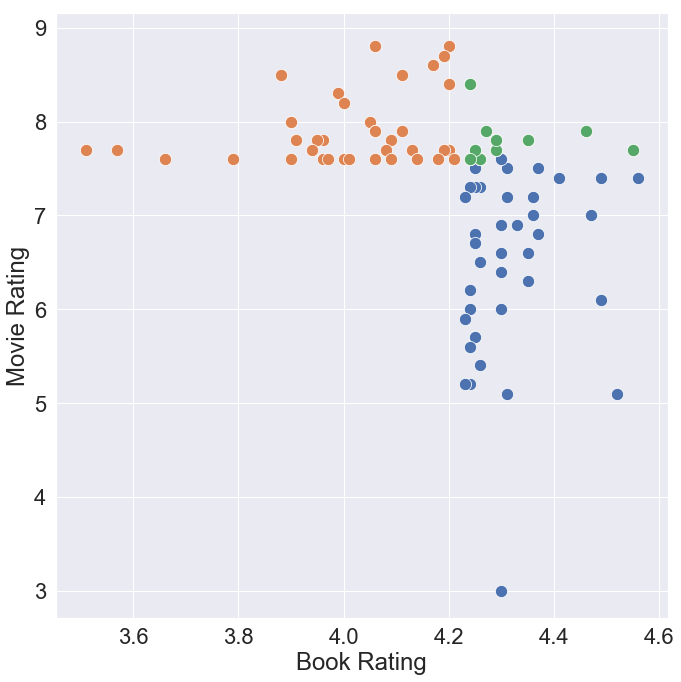

In [52]:
sns.set(font_scale=2) 
plt.figure(figsize=(10,10))

ax1 = sns.scatterplot(x = 'book_rating', y = 'movie_rating', data = top_50_books, s=150)
ax2 = sns.scatterplot(x = 'book_rating', y = 'movie_rating', data = top_50_movies, s=150)
ax3 = sns.scatterplot(x = 'book_rating', y = 'movie_rating', data = overlap, s=150)
plt.xlabel('Book Rating')
plt.ylabel('Movie Rating')
plt.tight_layout()
plt.show
plt.savefig('books_vs_movies.svg')

In [252]:
well_known_50_movies = book_movie.sort_values(by = 'movie_n_r_log', ascending = False).head(50)

In [254]:
well_known_50_books = book_movie.sort_values(by = 'book_n_r_log', ascending = False).head(50)

In [49]:
overlap = pd.merge(top_50_books, top_50_movies, how='inner', on=['book_rating', 'movie_rating'])

In [50]:
overlap

,book_title_x,book_rating,book_number_ratings_x,book_year_published_x,popularity_x,release_date_x,movie_runtime_x,movie_number_ratings_x,genres_x,movie_rating,book_title_y,book_number_ratings_y,book_year_published_y,popularity_y,release_date_y,movie_runtime_y,movie_number_ratings_y,genres_y
0,Harry Potter and the Prisoner of Azkaban,4.55,2317552,1999,28.46,"Monday, May 31, 2004",141,6037,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.7,Harry Potter and the Prisoner of Azkaban,2317552,1999,28.46,"Monday, May 31, 2004",141,6037,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
1,The Help,4.46,1858781,2009,7.49,"Tuesday, August 9, 2011",146,1966,"[{'id': 18, 'name': 'Drama'}]",7.9,The Help,1858781,2009,7.49,"Tuesday, August 9, 2011",146,1966,"[{'id': 18, 'name': 'Drama'}]"
2,The Lorax,4.35,248575,1971,1.69,"Monday, February 14, 1972",25,16,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",7.8,The Lorax,248575,1971,1.69,"Monday, February 14, 1972",25,16,"[{'id': 16, 'name': 'Animation'}, {'id': 10751..."
3,Gone with the Wind,4.29,988205,1936,14.24,"Friday, December 15, 1939",238,995,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",7.7,Gone with the Wind,988205,1936,14.24,"Friday, December 15, 1939",238,995,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."
4,The Velveteen Rabbit,4.29,201782,1922,0.74,"Thursday, January 1, 2009",97,9,"[{'id': 16, 'name': 'Animation'}, {'id': 18, '...",7.8,The Velveteen Rabbit,201782,1922,0.74,"Thursday, January 1, 2009",97,9,"[{'id': 16, 'name': 'Animation'}, {'id': 18, '..."
5,To Kill a Mockingbird,4.27,3879494,1960,14.28,"Tuesday, December 25, 1962",129,676,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",7.9,To Kill a Mockingbird,3879494,1960,14.28,"Tuesday, December 25, 1962",129,676,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name..."
6,Me Before You,4.26,925854,2012,34.35,"Thursday, June 2, 2016",110,2674,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",7.6,Me Before You,925854,2012,34.35,"Thursday, June 2, 2016",110,2674,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."
7,Me Before You,4.26,925854,2012,34.35,"Thursday, June 2, 2016",110,2674,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",7.6,The Princess Bride,703742,1973,15.15,"Friday, September 18, 1987",98,1518,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751..."
8,The Princess Bride,4.26,703742,1973,15.15,"Friday, September 18, 1987",98,1518,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",7.6,Me Before You,925854,2012,34.35,"Thursday, June 2, 2016",110,2674,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."
9,The Princess Bride,4.26,703742,1973,15.15,"Friday, September 18, 1987",98,1518,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",7.6,The Princess Bride,703742,1973,15.15,"Friday, September 18, 1987",98,1518,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751..."
